# Pdfmatcher
### by Robin
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 40px;" align='left'/>
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 40px;" align='left'/>
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 40px;" align='left'/>
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 40px;" align='left'/>
<img src="img/pdf-file-format-symbol.png" alt="Drawing" style="width: 40px;" align='left'/>


## Challenge
#### Help annotaters to process similar docs
- find duplicates
- find similar docs
- find outliers

## Approach
#text #layout ##experimental 

## Duplicate hunting

In [109]:
import glob
filelist = glob.glob("/home/becode/dr-robin/kleister-charity/documents/*.pdf")
print('Number of files:',len(filelist))
print('Filenames:', filelist[:1])

Number of files: 3414
Filenames: ['/home/becode/dr-robin/kleister-charity/documents/511c29acc44700cb2f91b615007a46e1.pdf']


In [2]:
#Duplicate hunting using pdfhash
import sys
import os
import hashlib

#file_dict = defaultdict(list)
hashlist=[]
for filename in filelist:
    with open(filename, 'rb') as f: # Use file to refer to the file object
        data = f.read()
    file_hash = hashlib.md5(data).digest()
    hashlist.append(file_hash)

In [197]:
hashlist[:10]

[b'Q\x1c)\xac\xc4G\x00\xcb/\x91\xb6\x15\x00zF\xe1',
 b'i\x1a\xc7\xbf:0gP\xd7W[\xe4\x87\xf2\xa2\xbc',
 b'\x9a\xe0\x9d-\x1e!\xcf\x05\xadl\xd3\xaf\xb3\x00\xcfH',
 b'PRs/\x08\xdd(U+\xff$\xf1\x91^\xd4"',
 b'\x1d\x1d\xf2\x96\x18\xc9T\nmo\x02jF=\x94\xc9',
 b'\xc2\xc4\xc9U&cn\x83ht]A \x91\x82j',
 b'o\t\xdaw\x154}\x9dS\xb9\x0eI\x15\xb4E\x92',
 b'\x13\xa5o\xf6\xf6\xa4\xca\xe5\x95\x88\xe0\x13O\xf7\xa3\x10',
 b'\x92\xbc5\xe9\xb5u\x07\xbe\xf0a\x0c\xda\x87\xa0\x97\xc0',
 b'\xa3\xa2\x97\xe9#%4A\x8f\x8aH\x01#\x1dk\x80']

In [5]:
#Duplicate hunting using filesize
import pandas as pd
import os

def filesizes(filelist):
    result=[]
    for f in filelist:
        #Retrieve file size
        filesize = os.path.getsize(f)
        result.append(filesize)
    #Put results in df
    tmp = pd.DataFrame({'filename':f, 'filesize': result})
    #Filter df for duplicates
    dupes = tmp['filesize'].duplicated(keep=False)
    #print(tmp['filesize'][dupes].index)
    dupelist = tmp[['filesize','filename']][dupes]
    print(dupelist)
    return dupelist 

dupelist = filesizes(filelist)

      filesize                                           filename
901     705206  /home/becode/dr-robin/kleister-charity/documen...
931     705206  /home/becode/dr-robin/kleister-charity/documen...
1049    429092  /home/becode/dr-robin/kleister-charity/documen...
1725   5359704  /home/becode/dr-robin/kleister-charity/documen...
2159   5359704  /home/becode/dr-robin/kleister-charity/documen...
2174    247310  /home/becode/dr-robin/kleister-charity/documen...
2385    429092  /home/becode/dr-robin/kleister-charity/documen...
2771    247310  /home/becode/dr-robin/kleister-charity/documen...


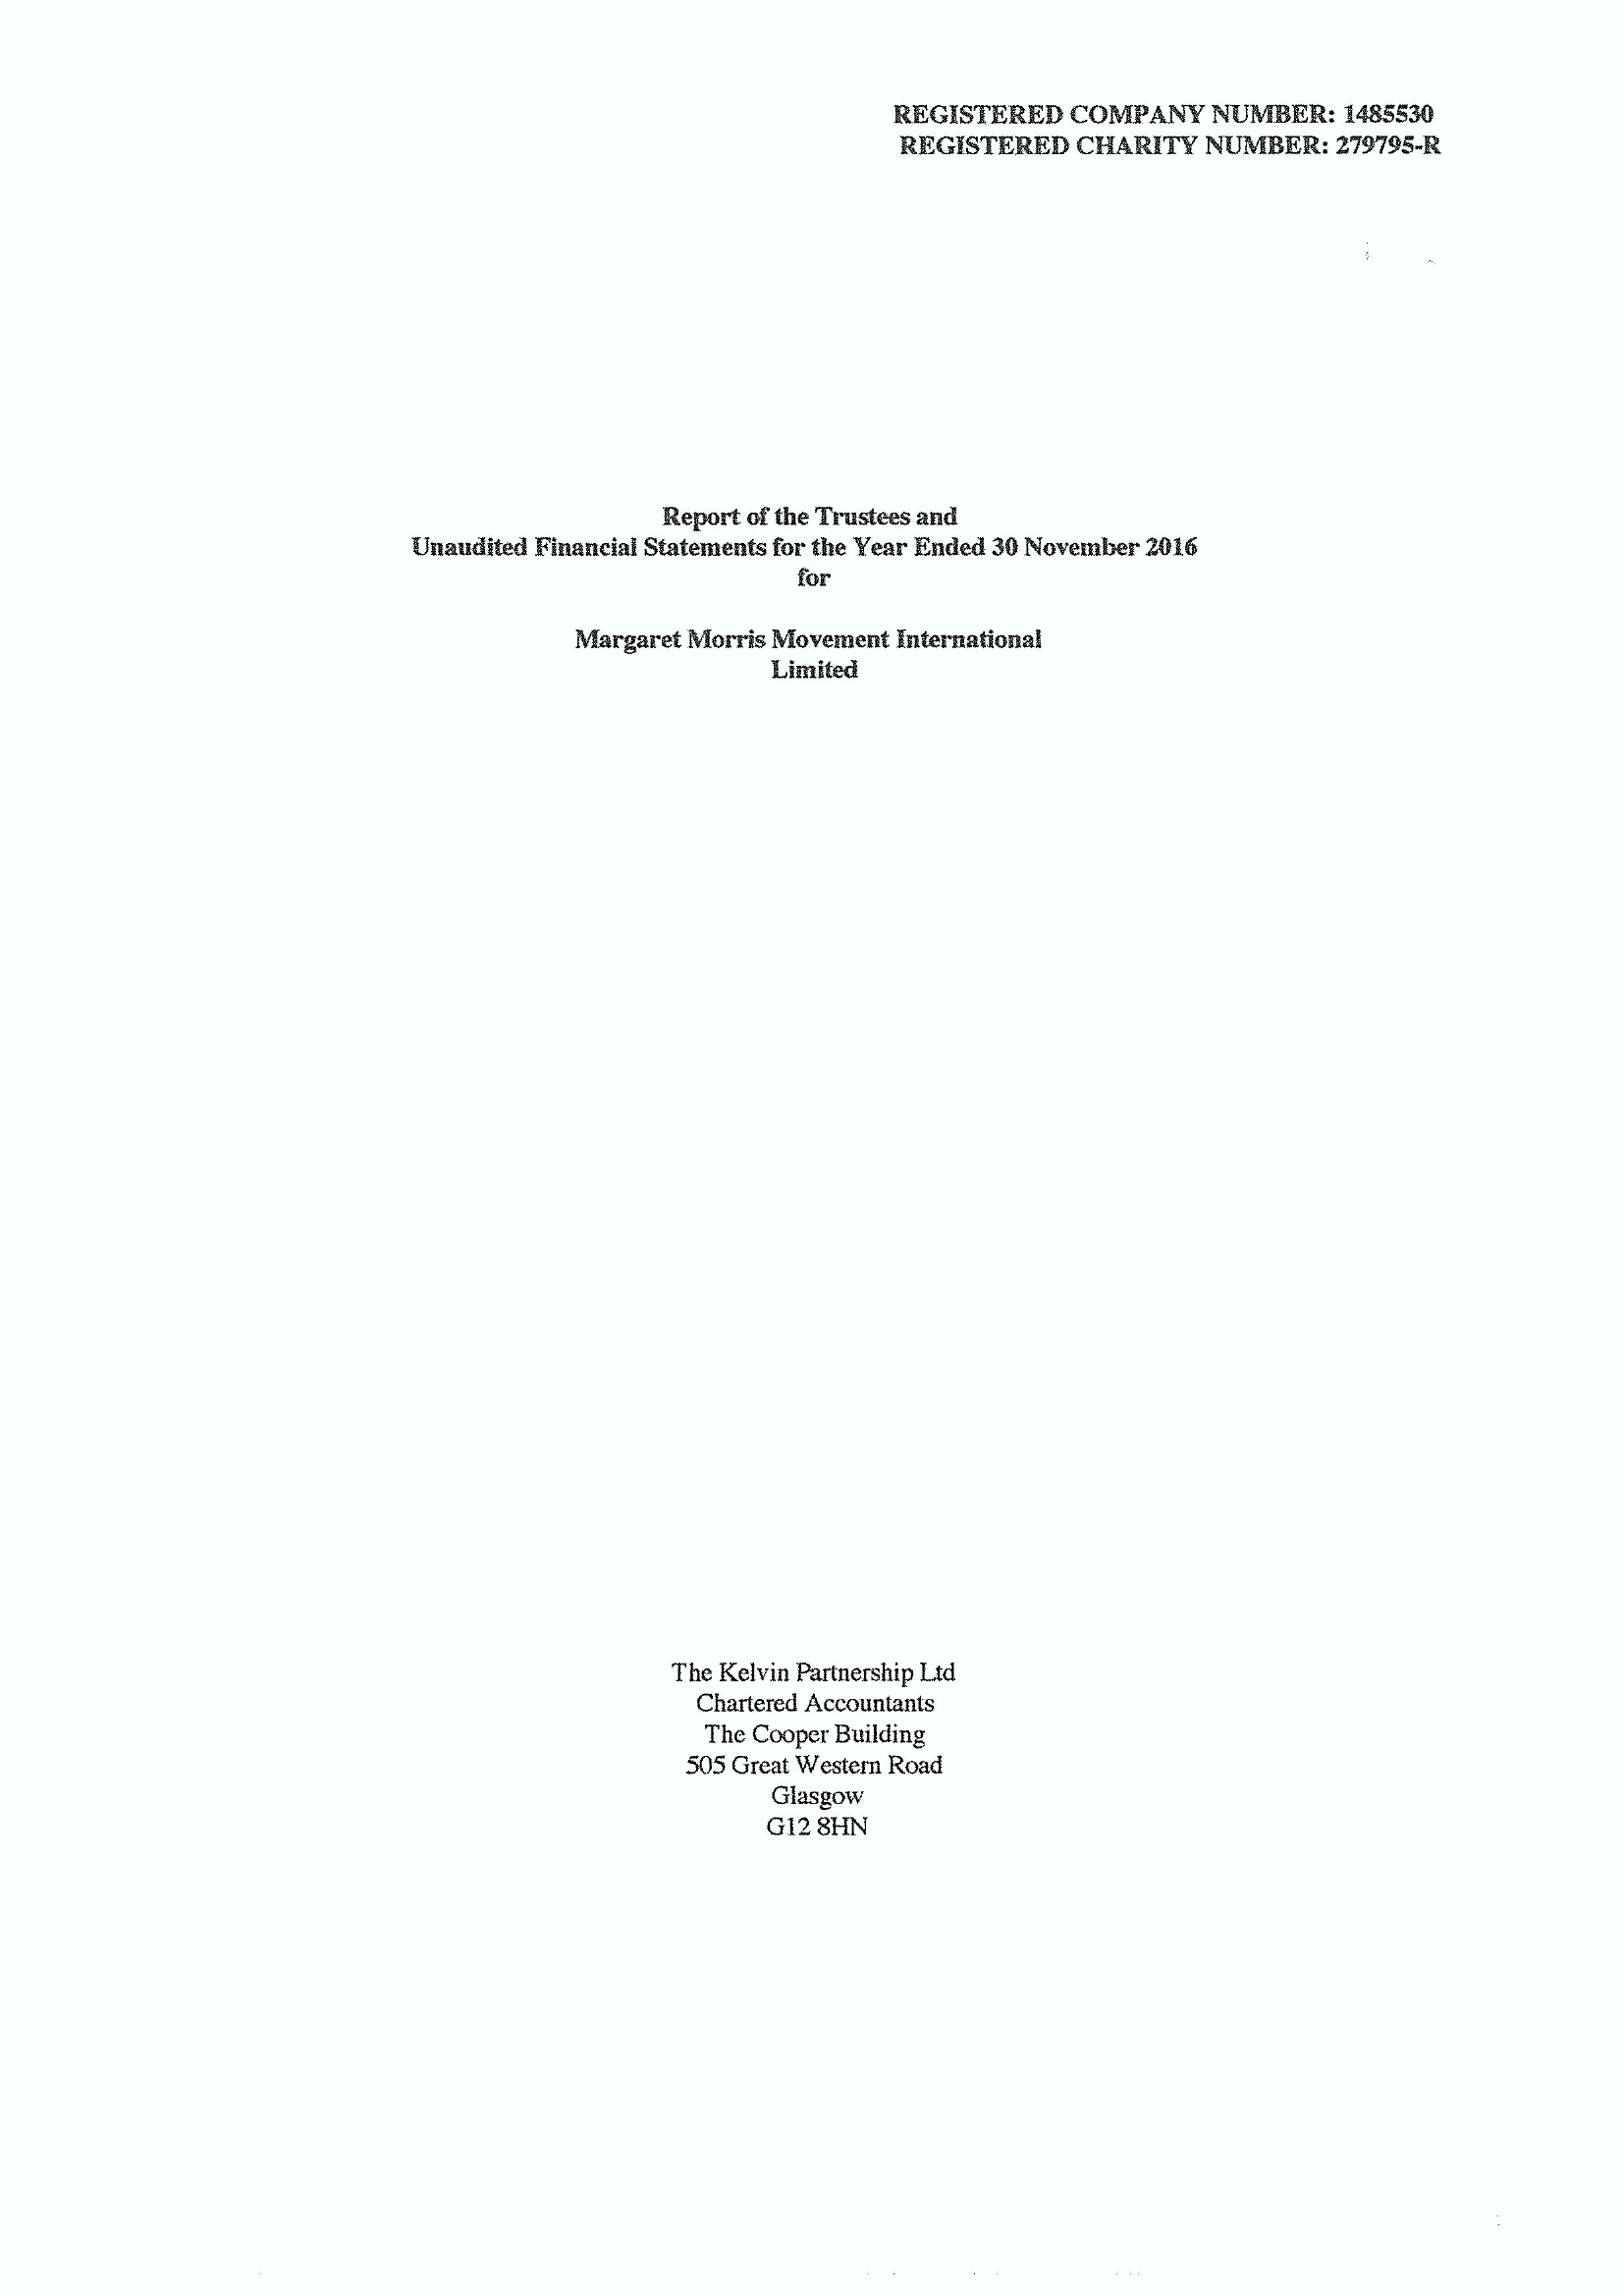

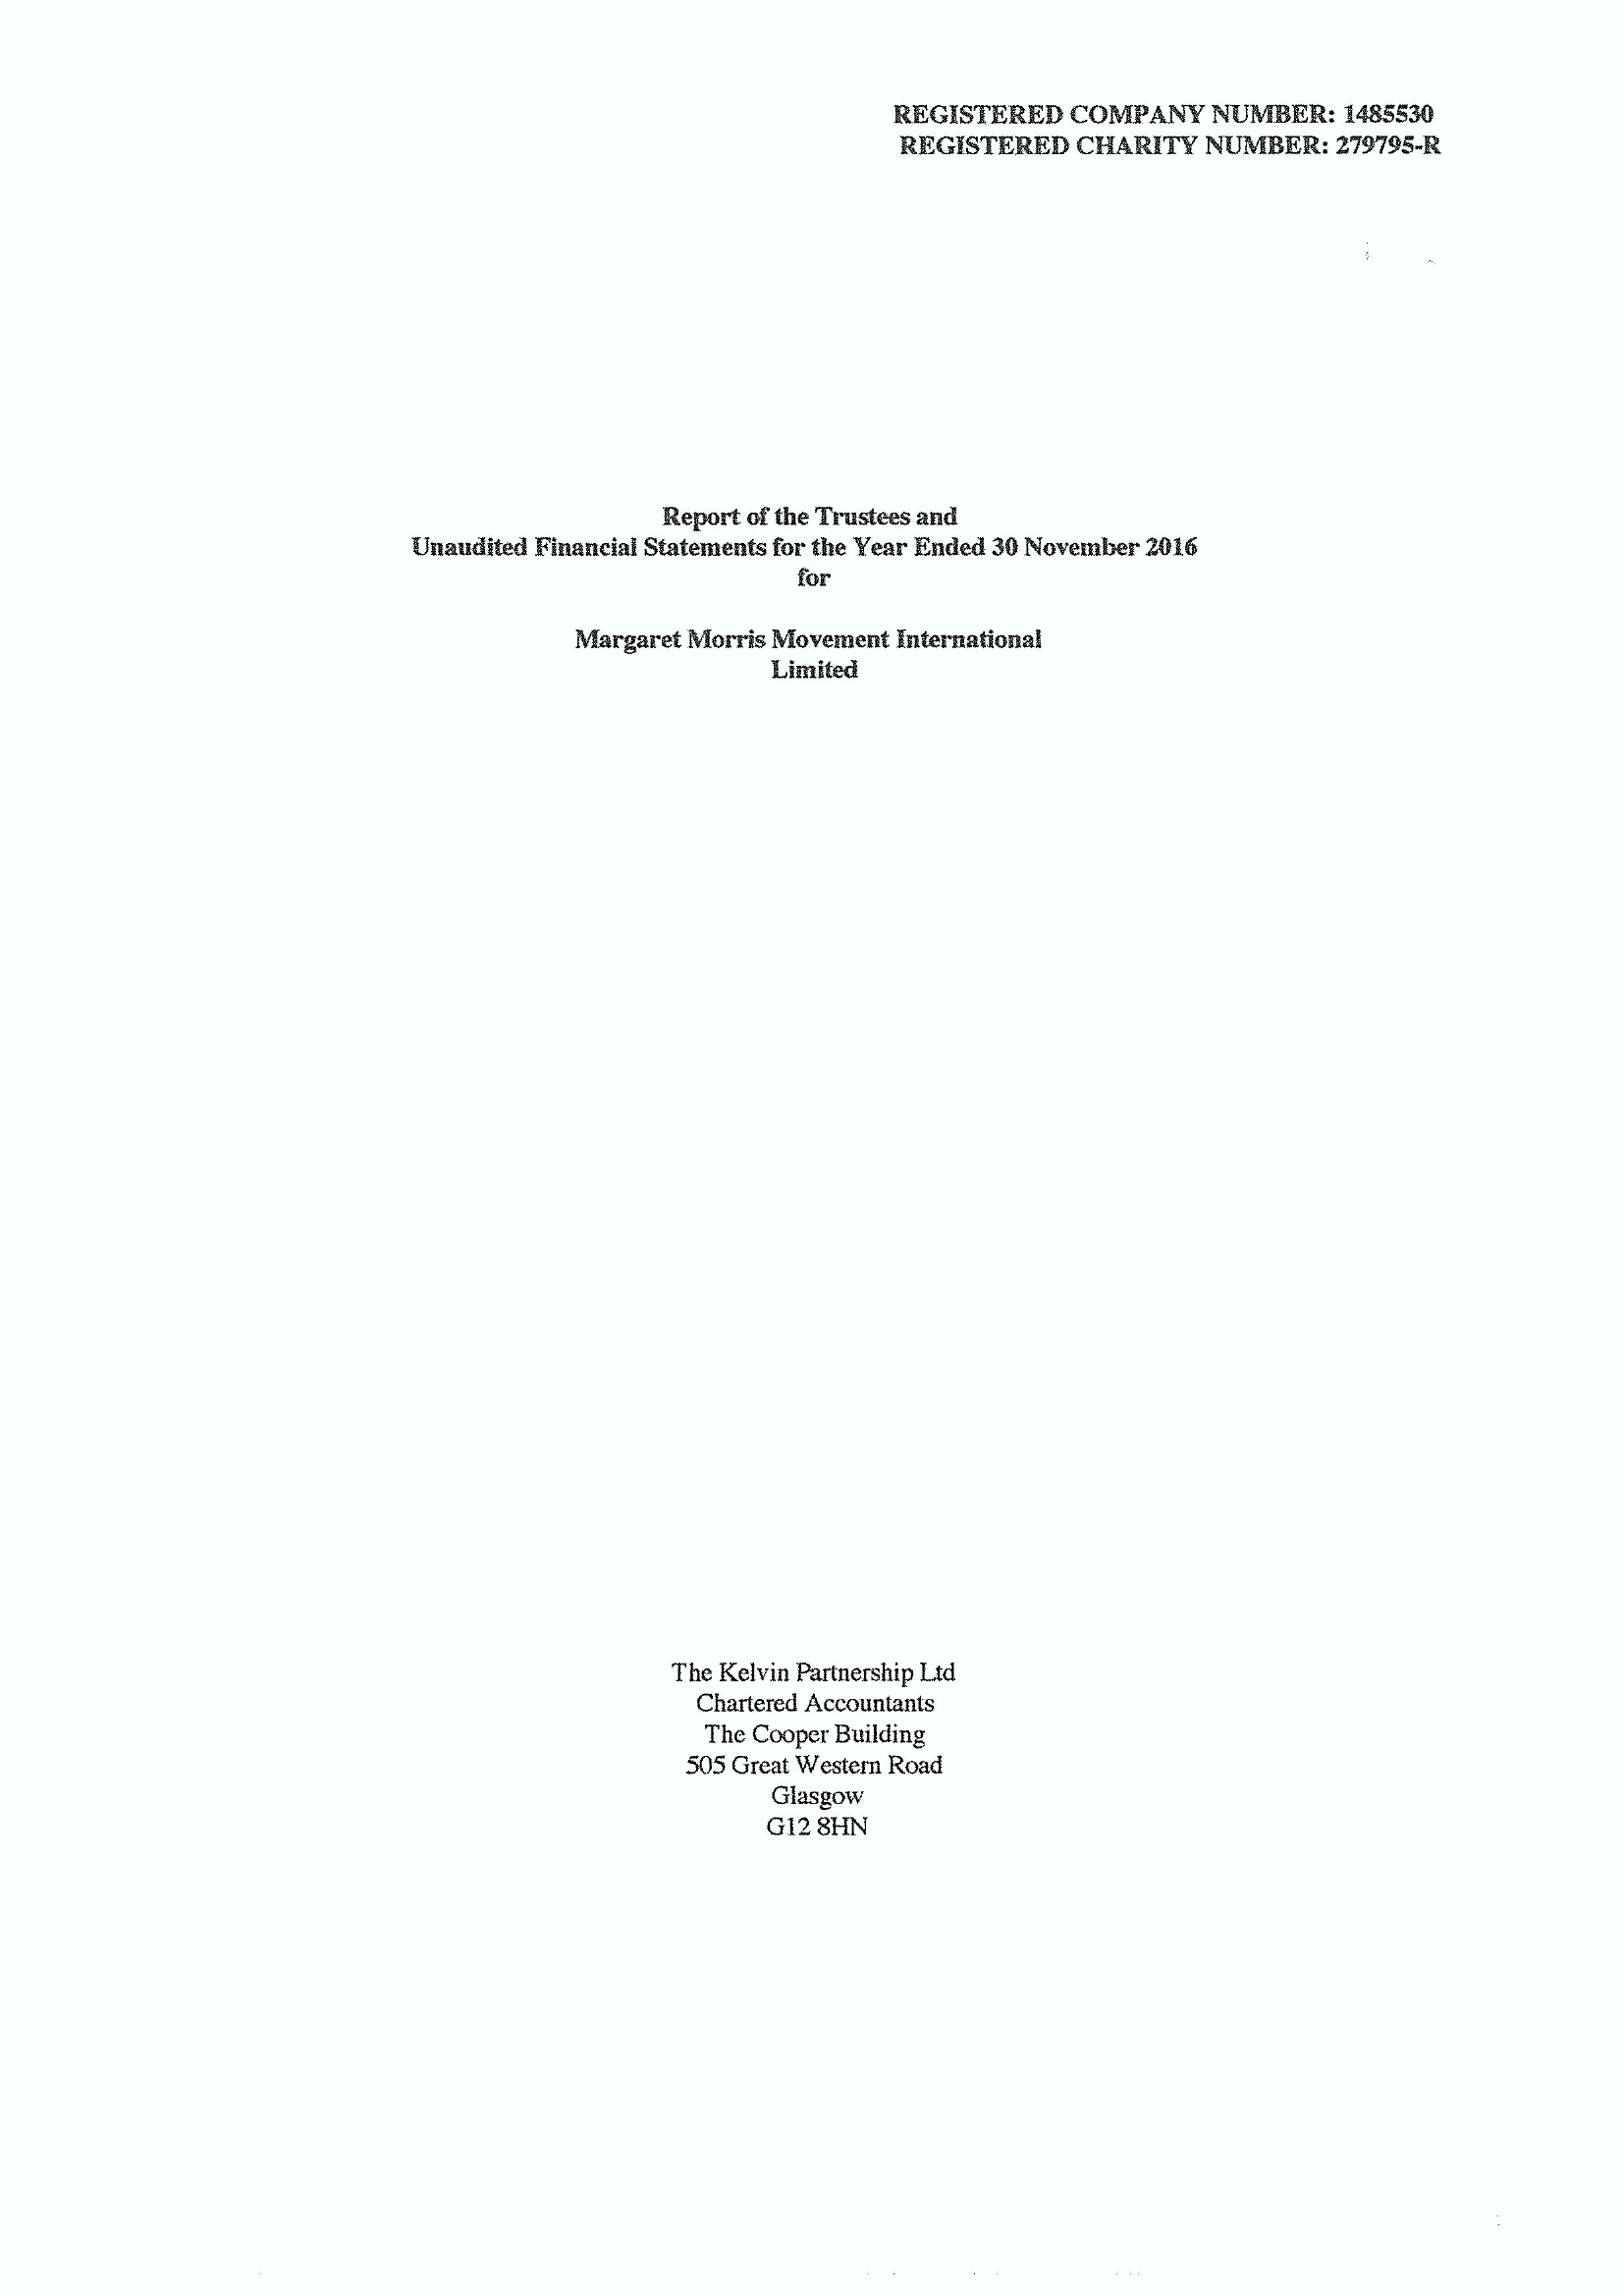

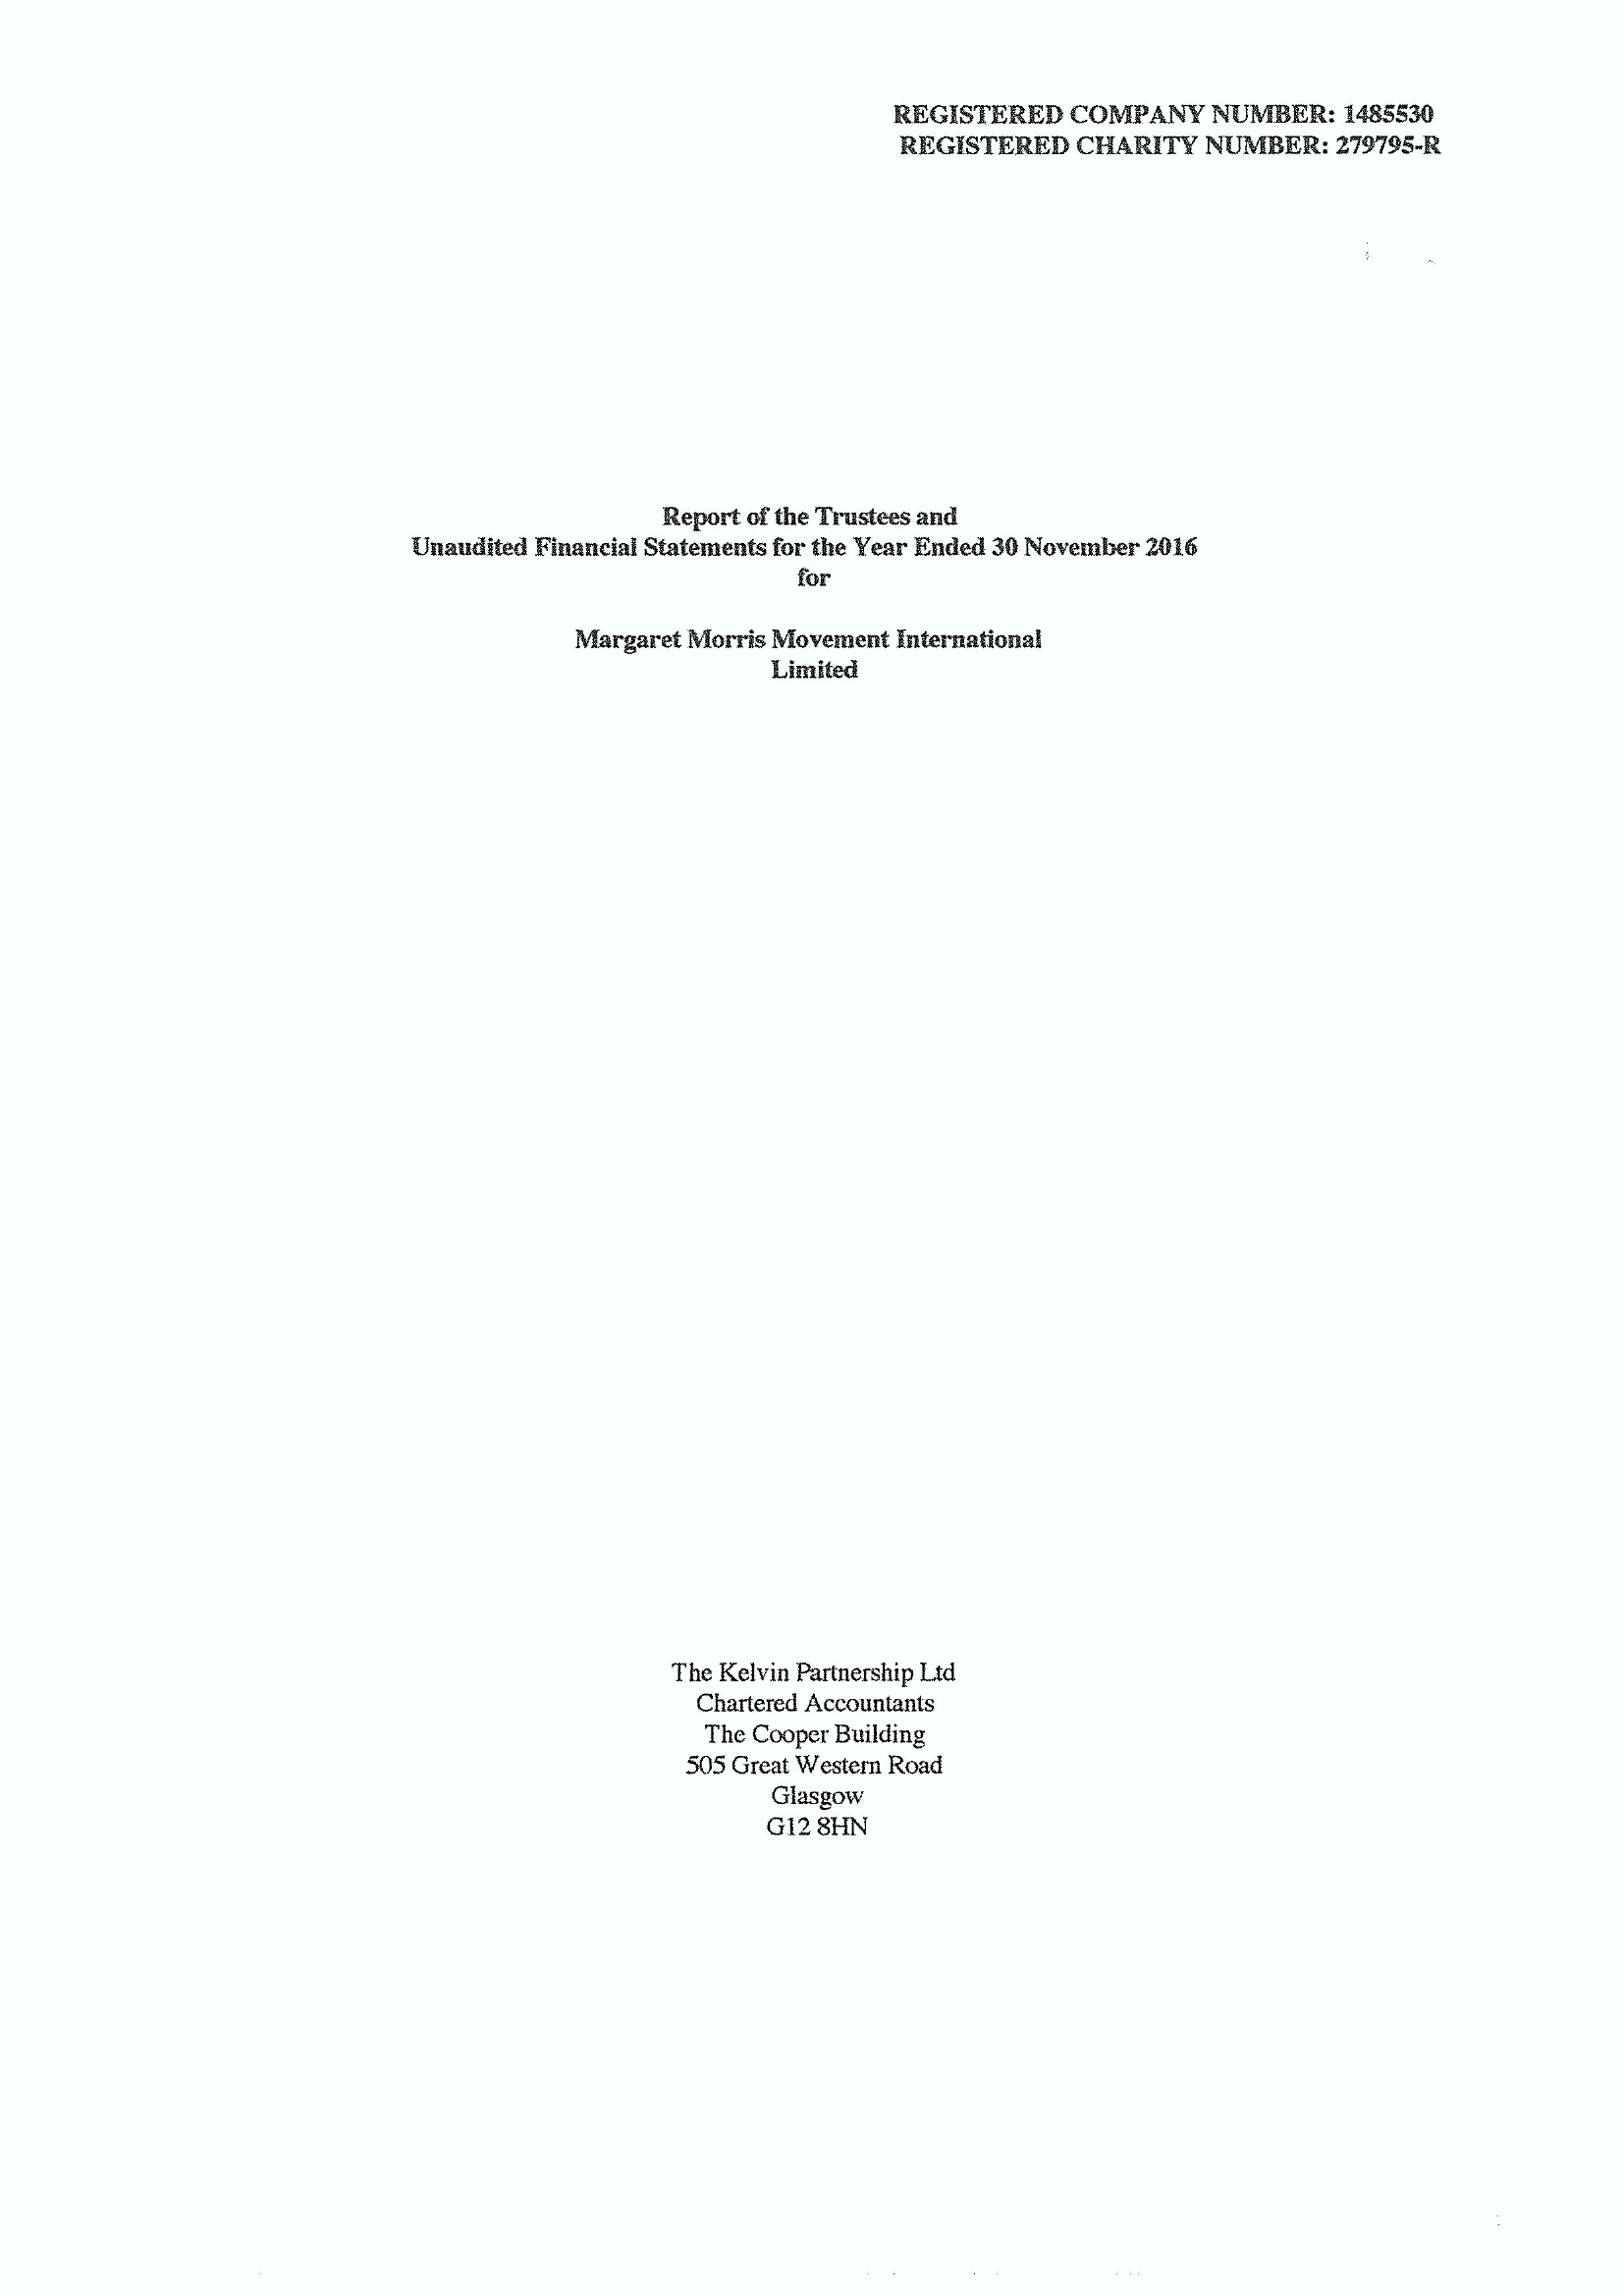

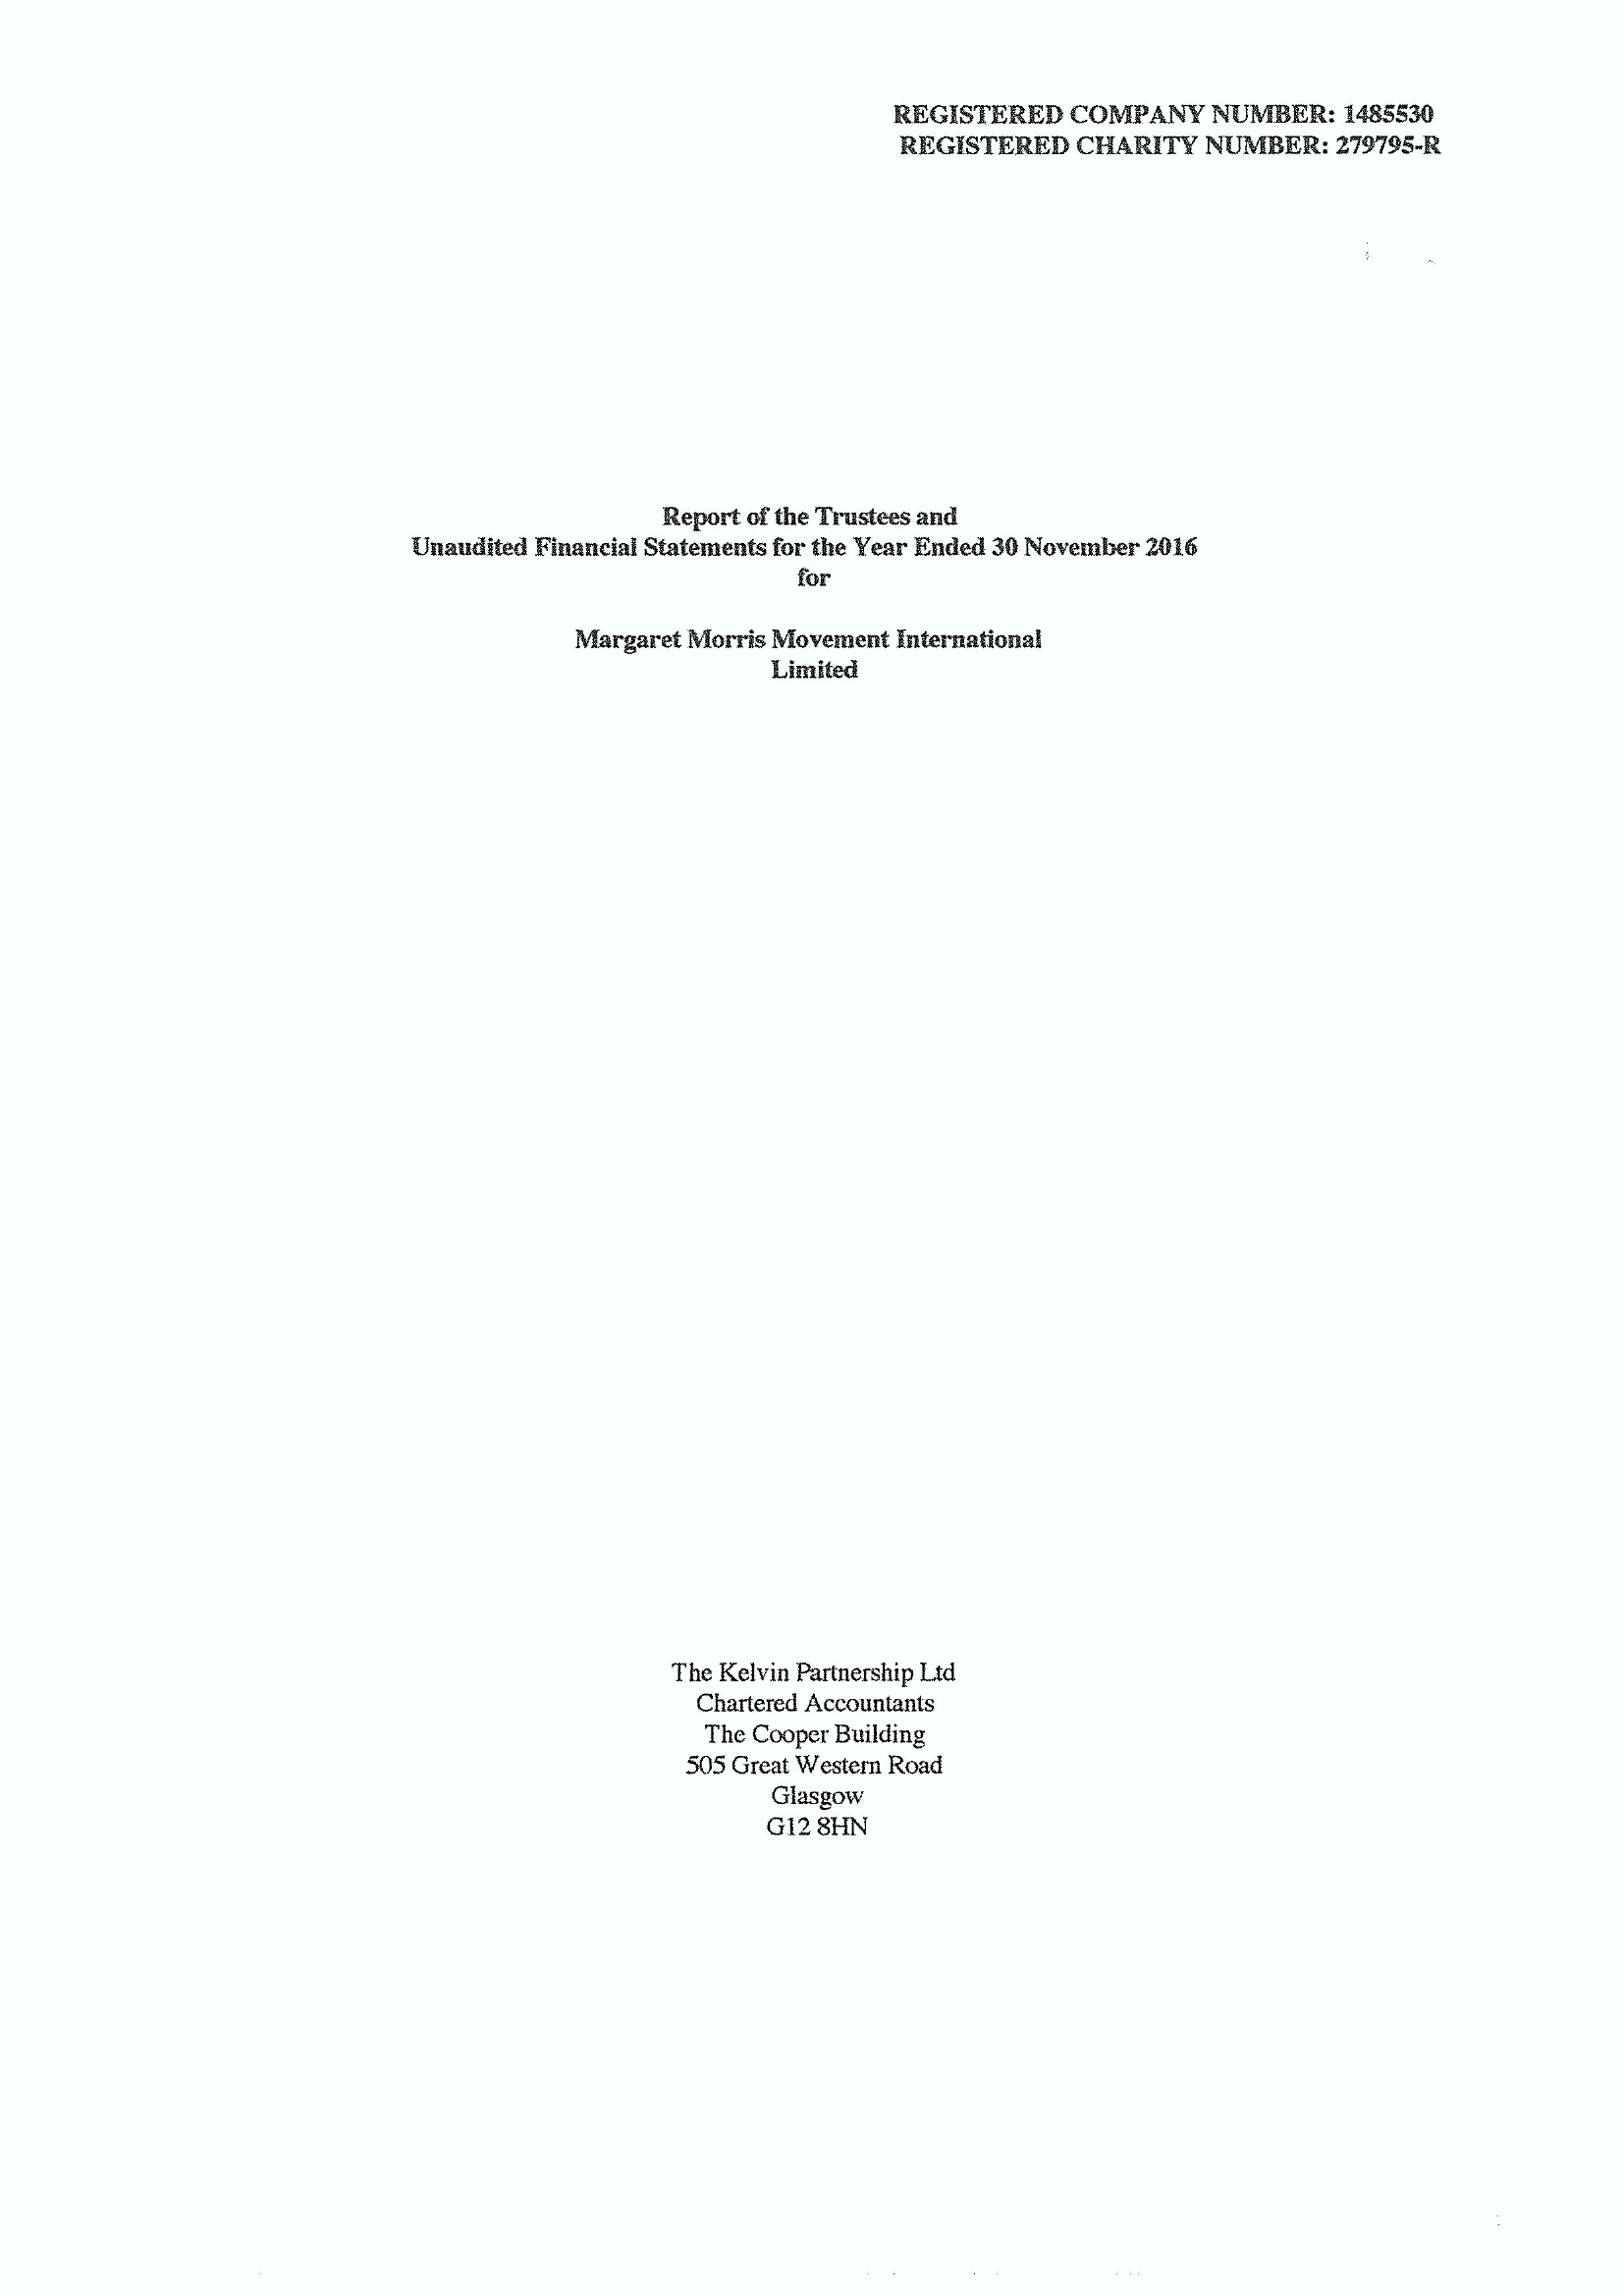

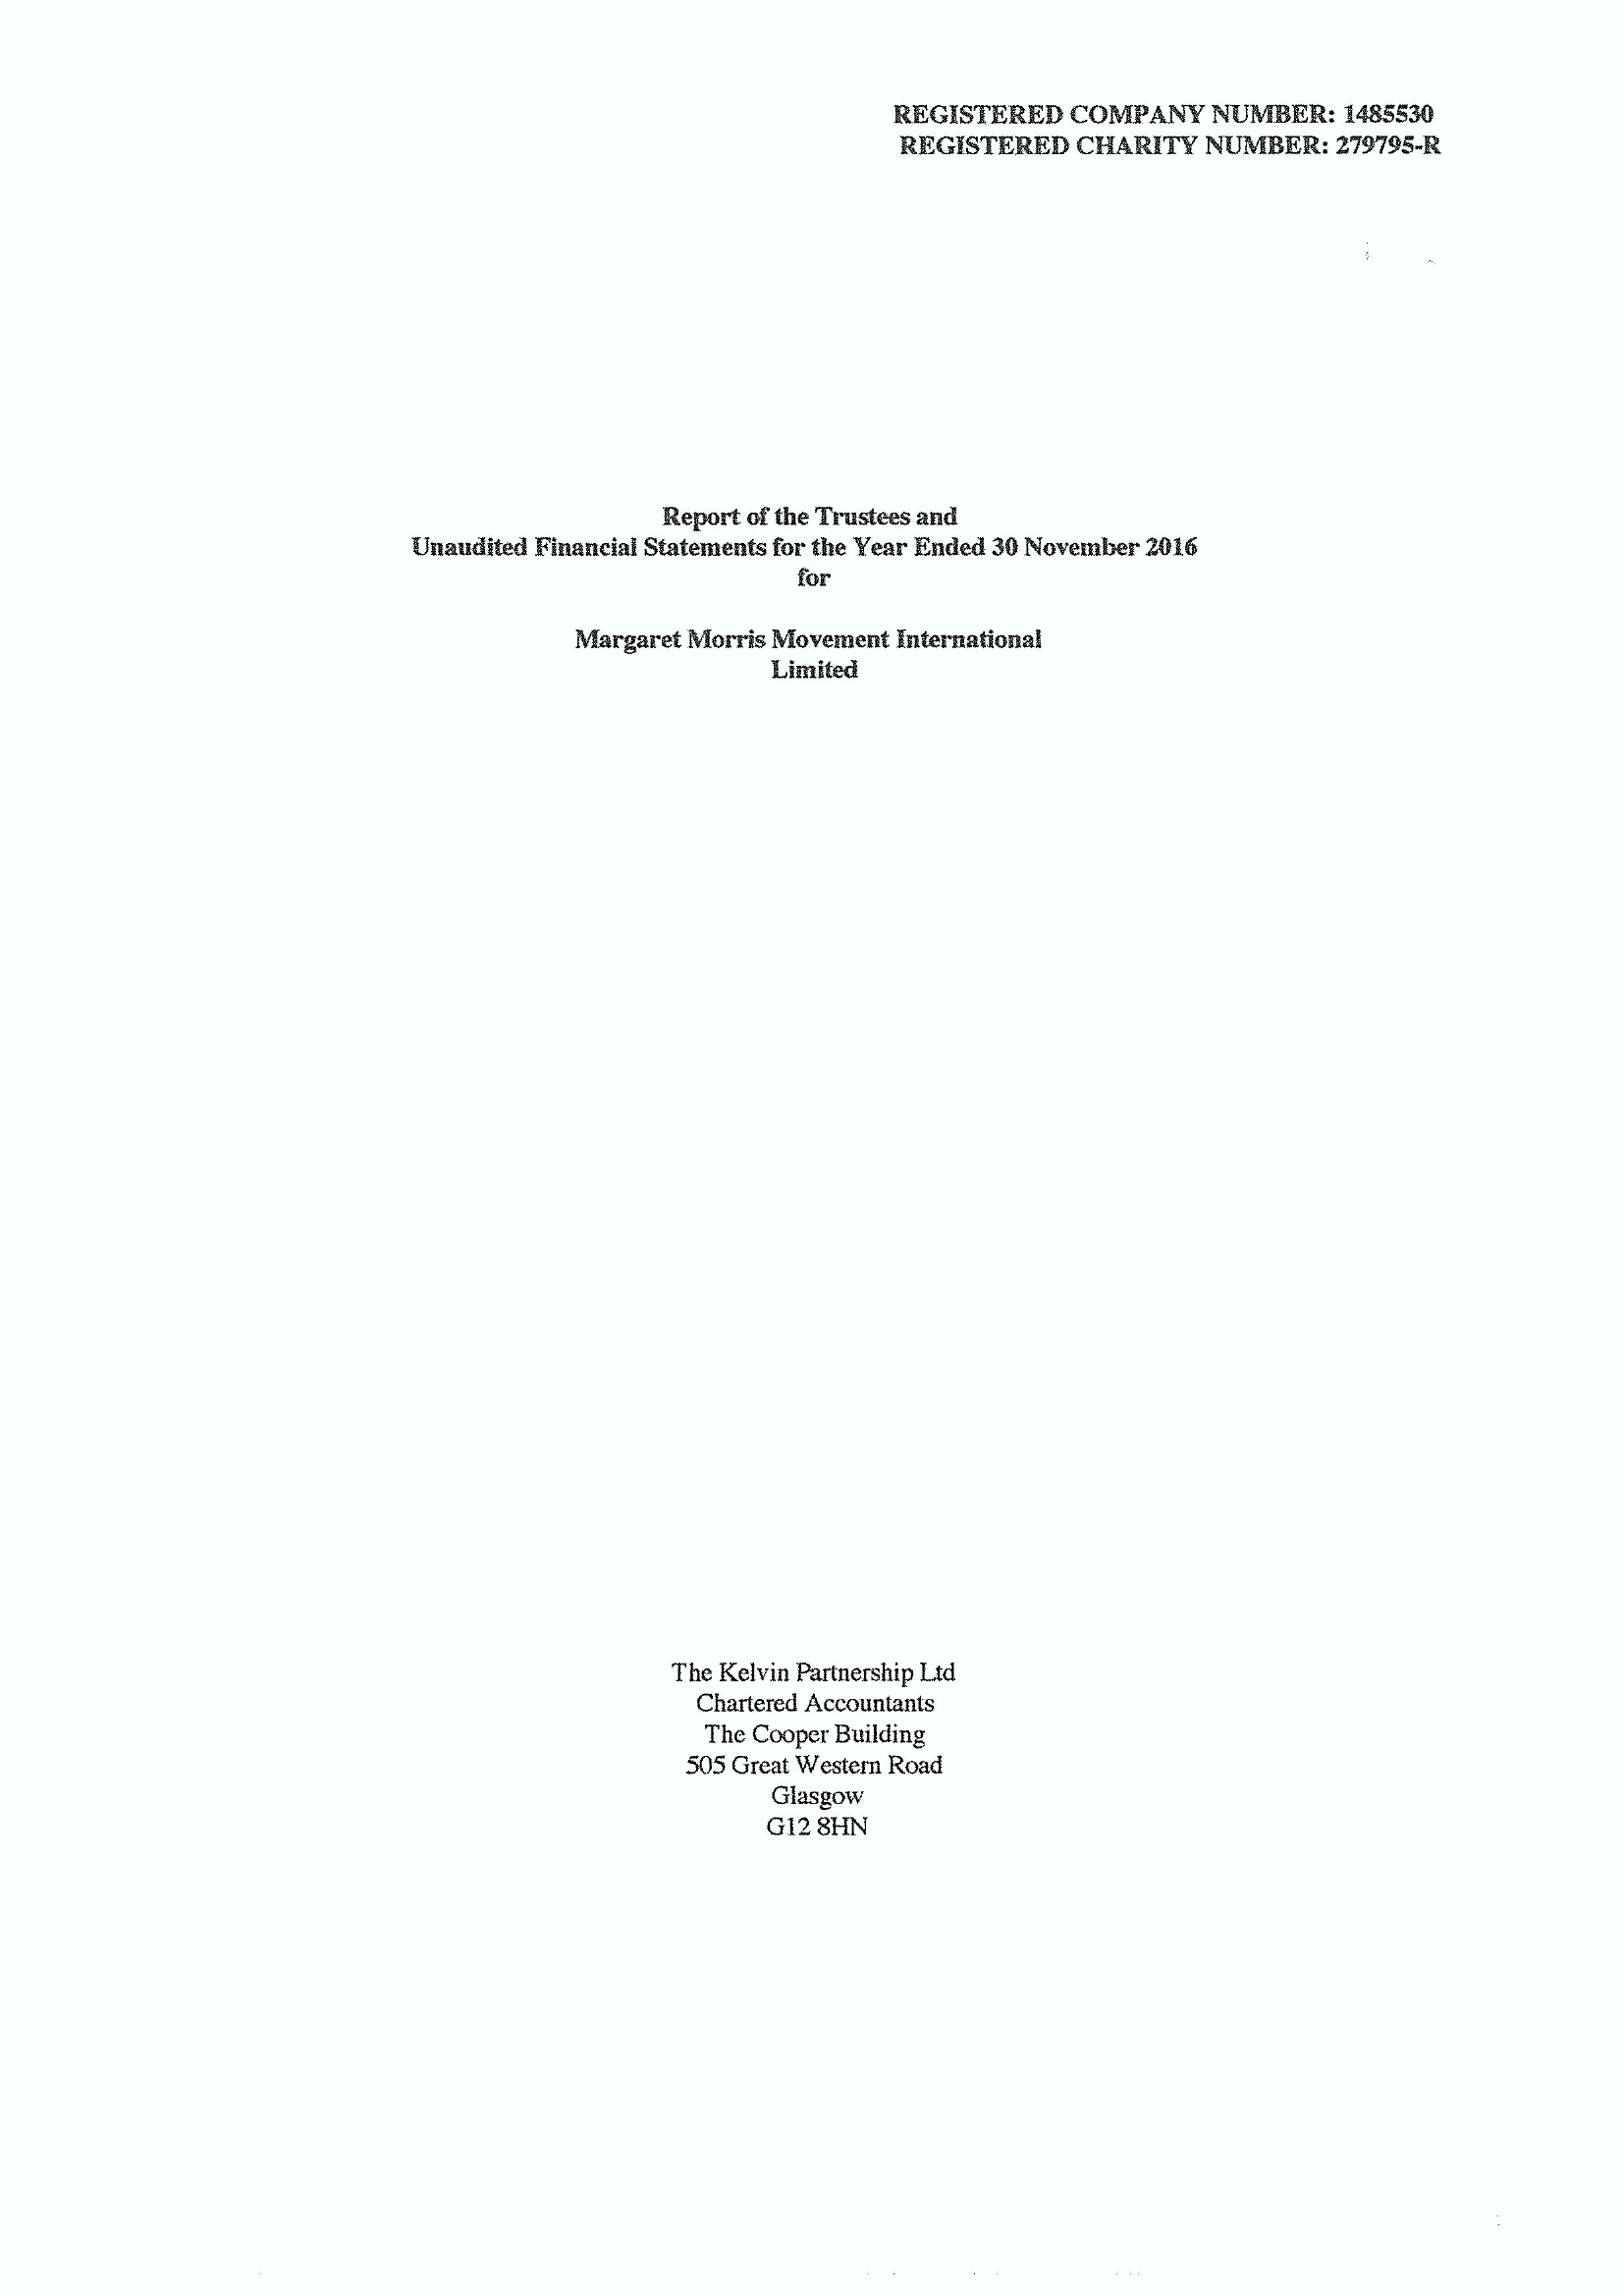

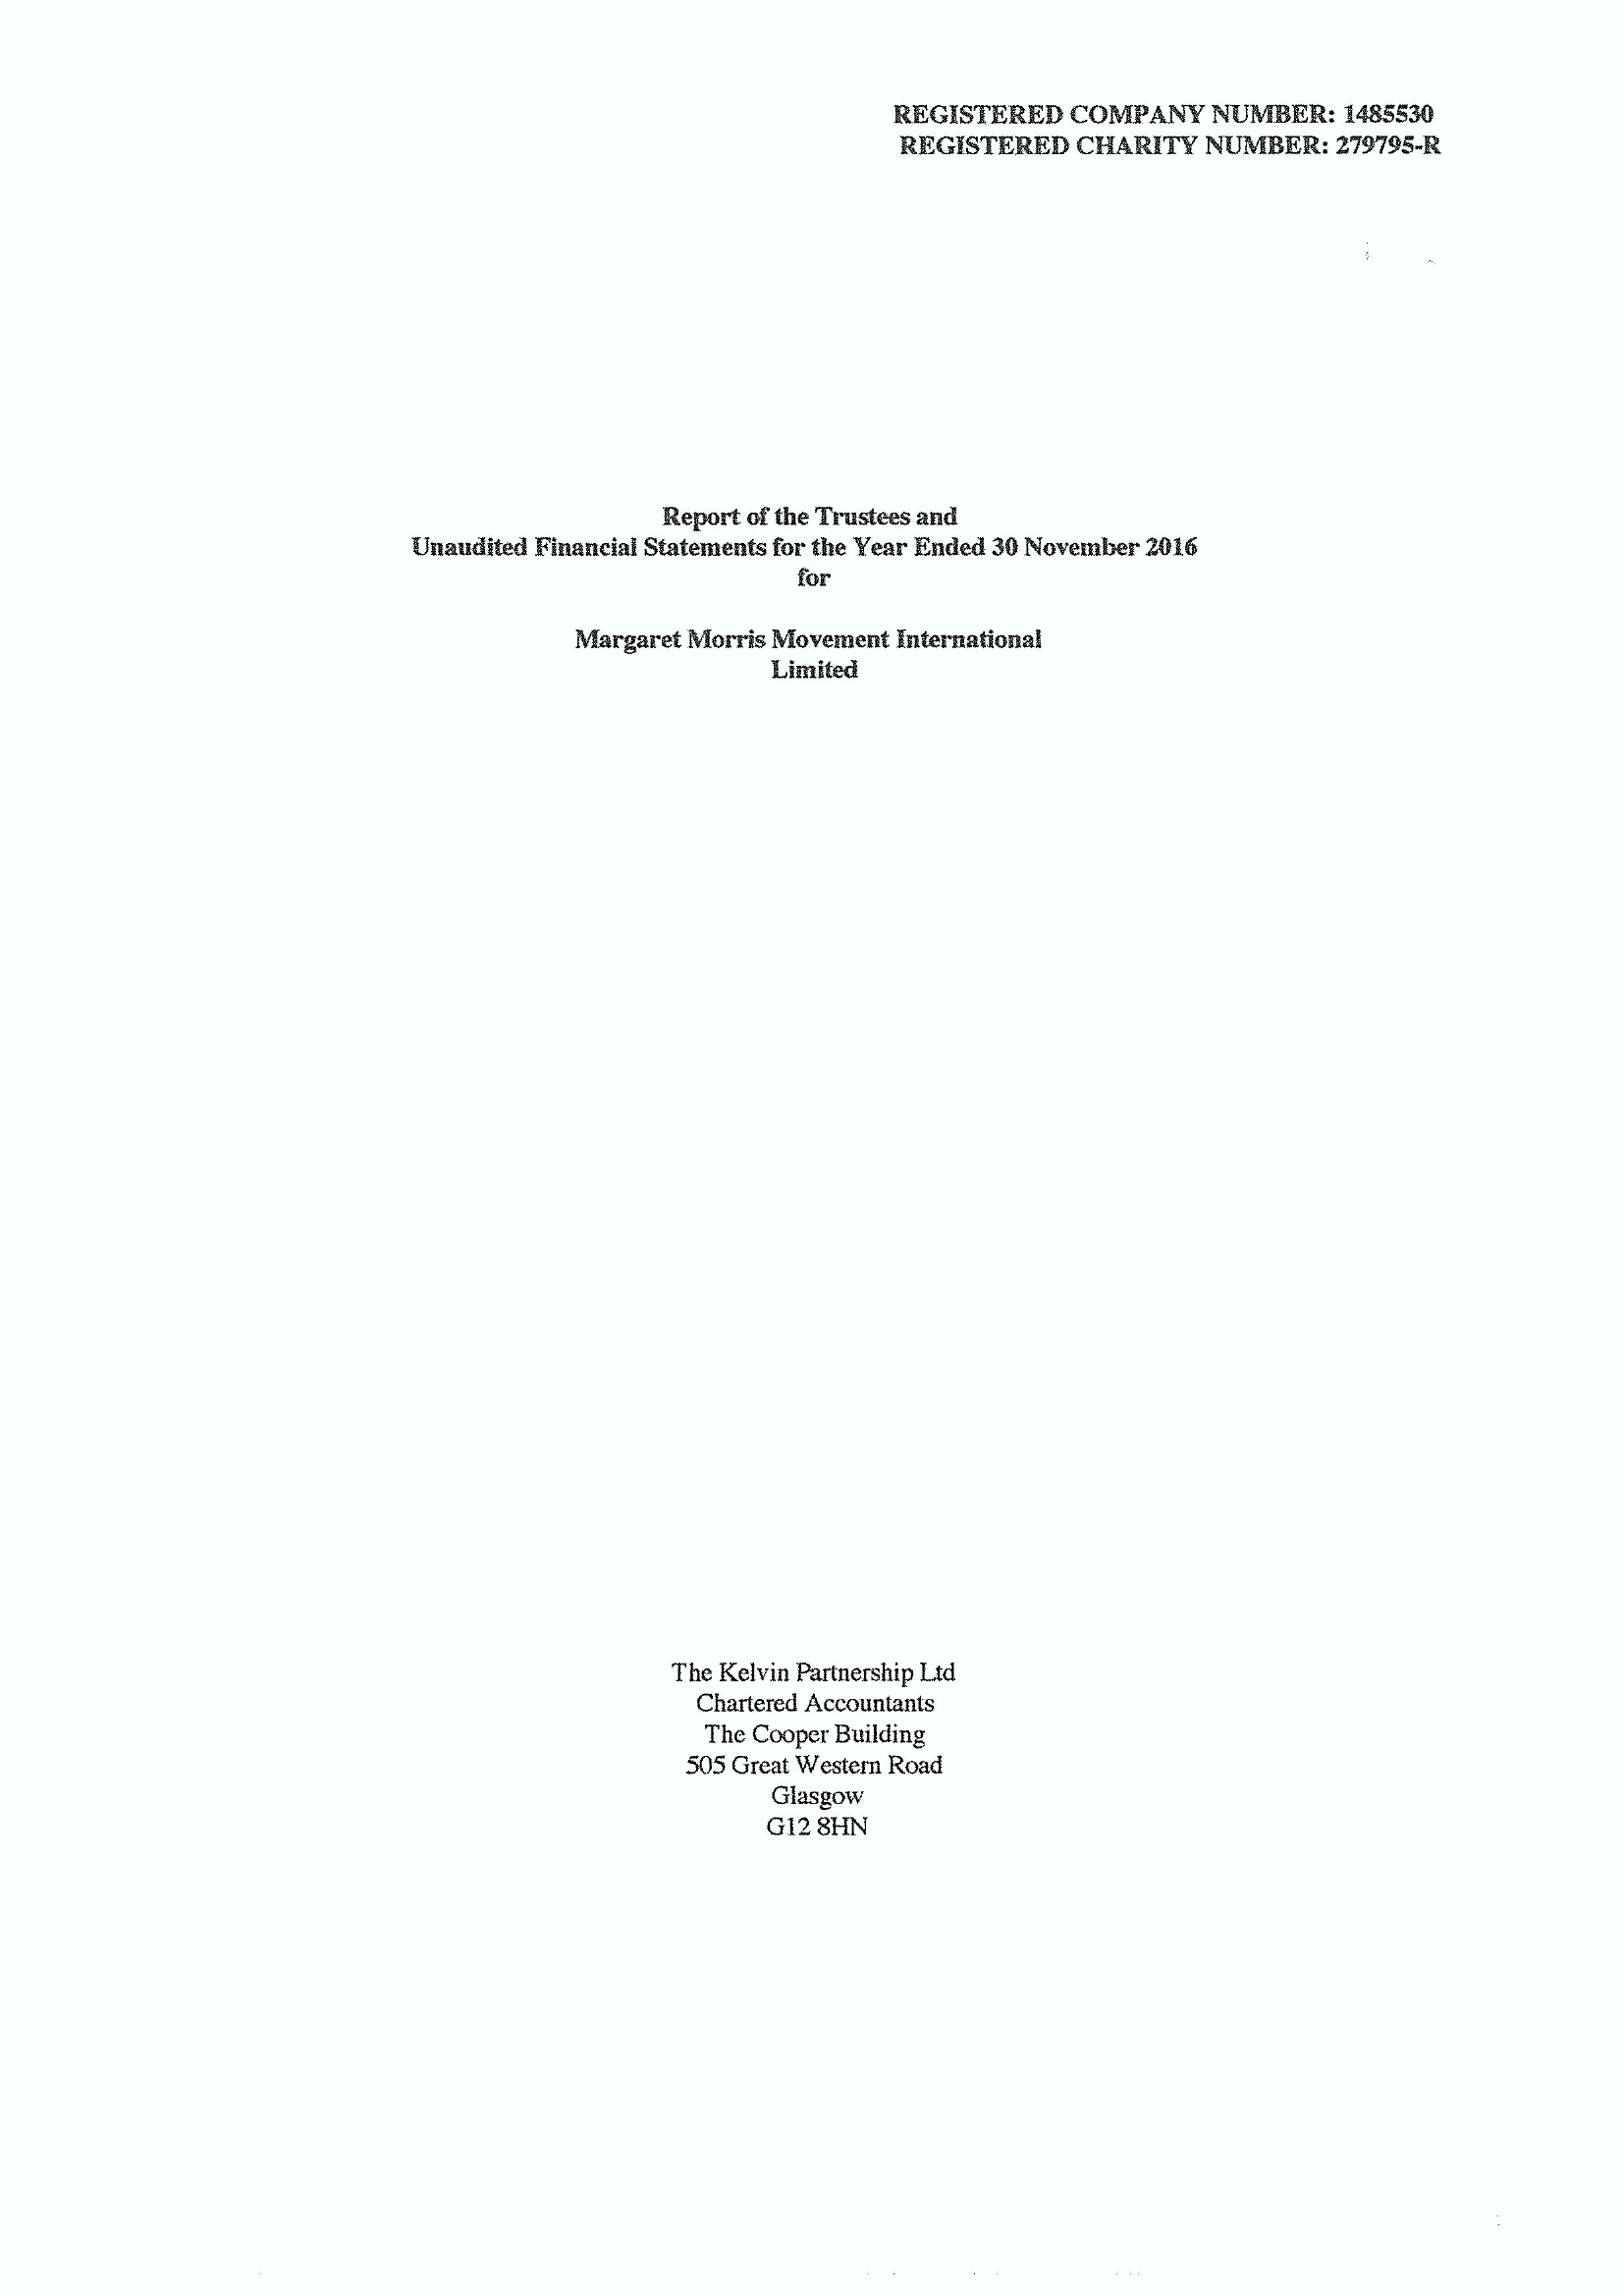

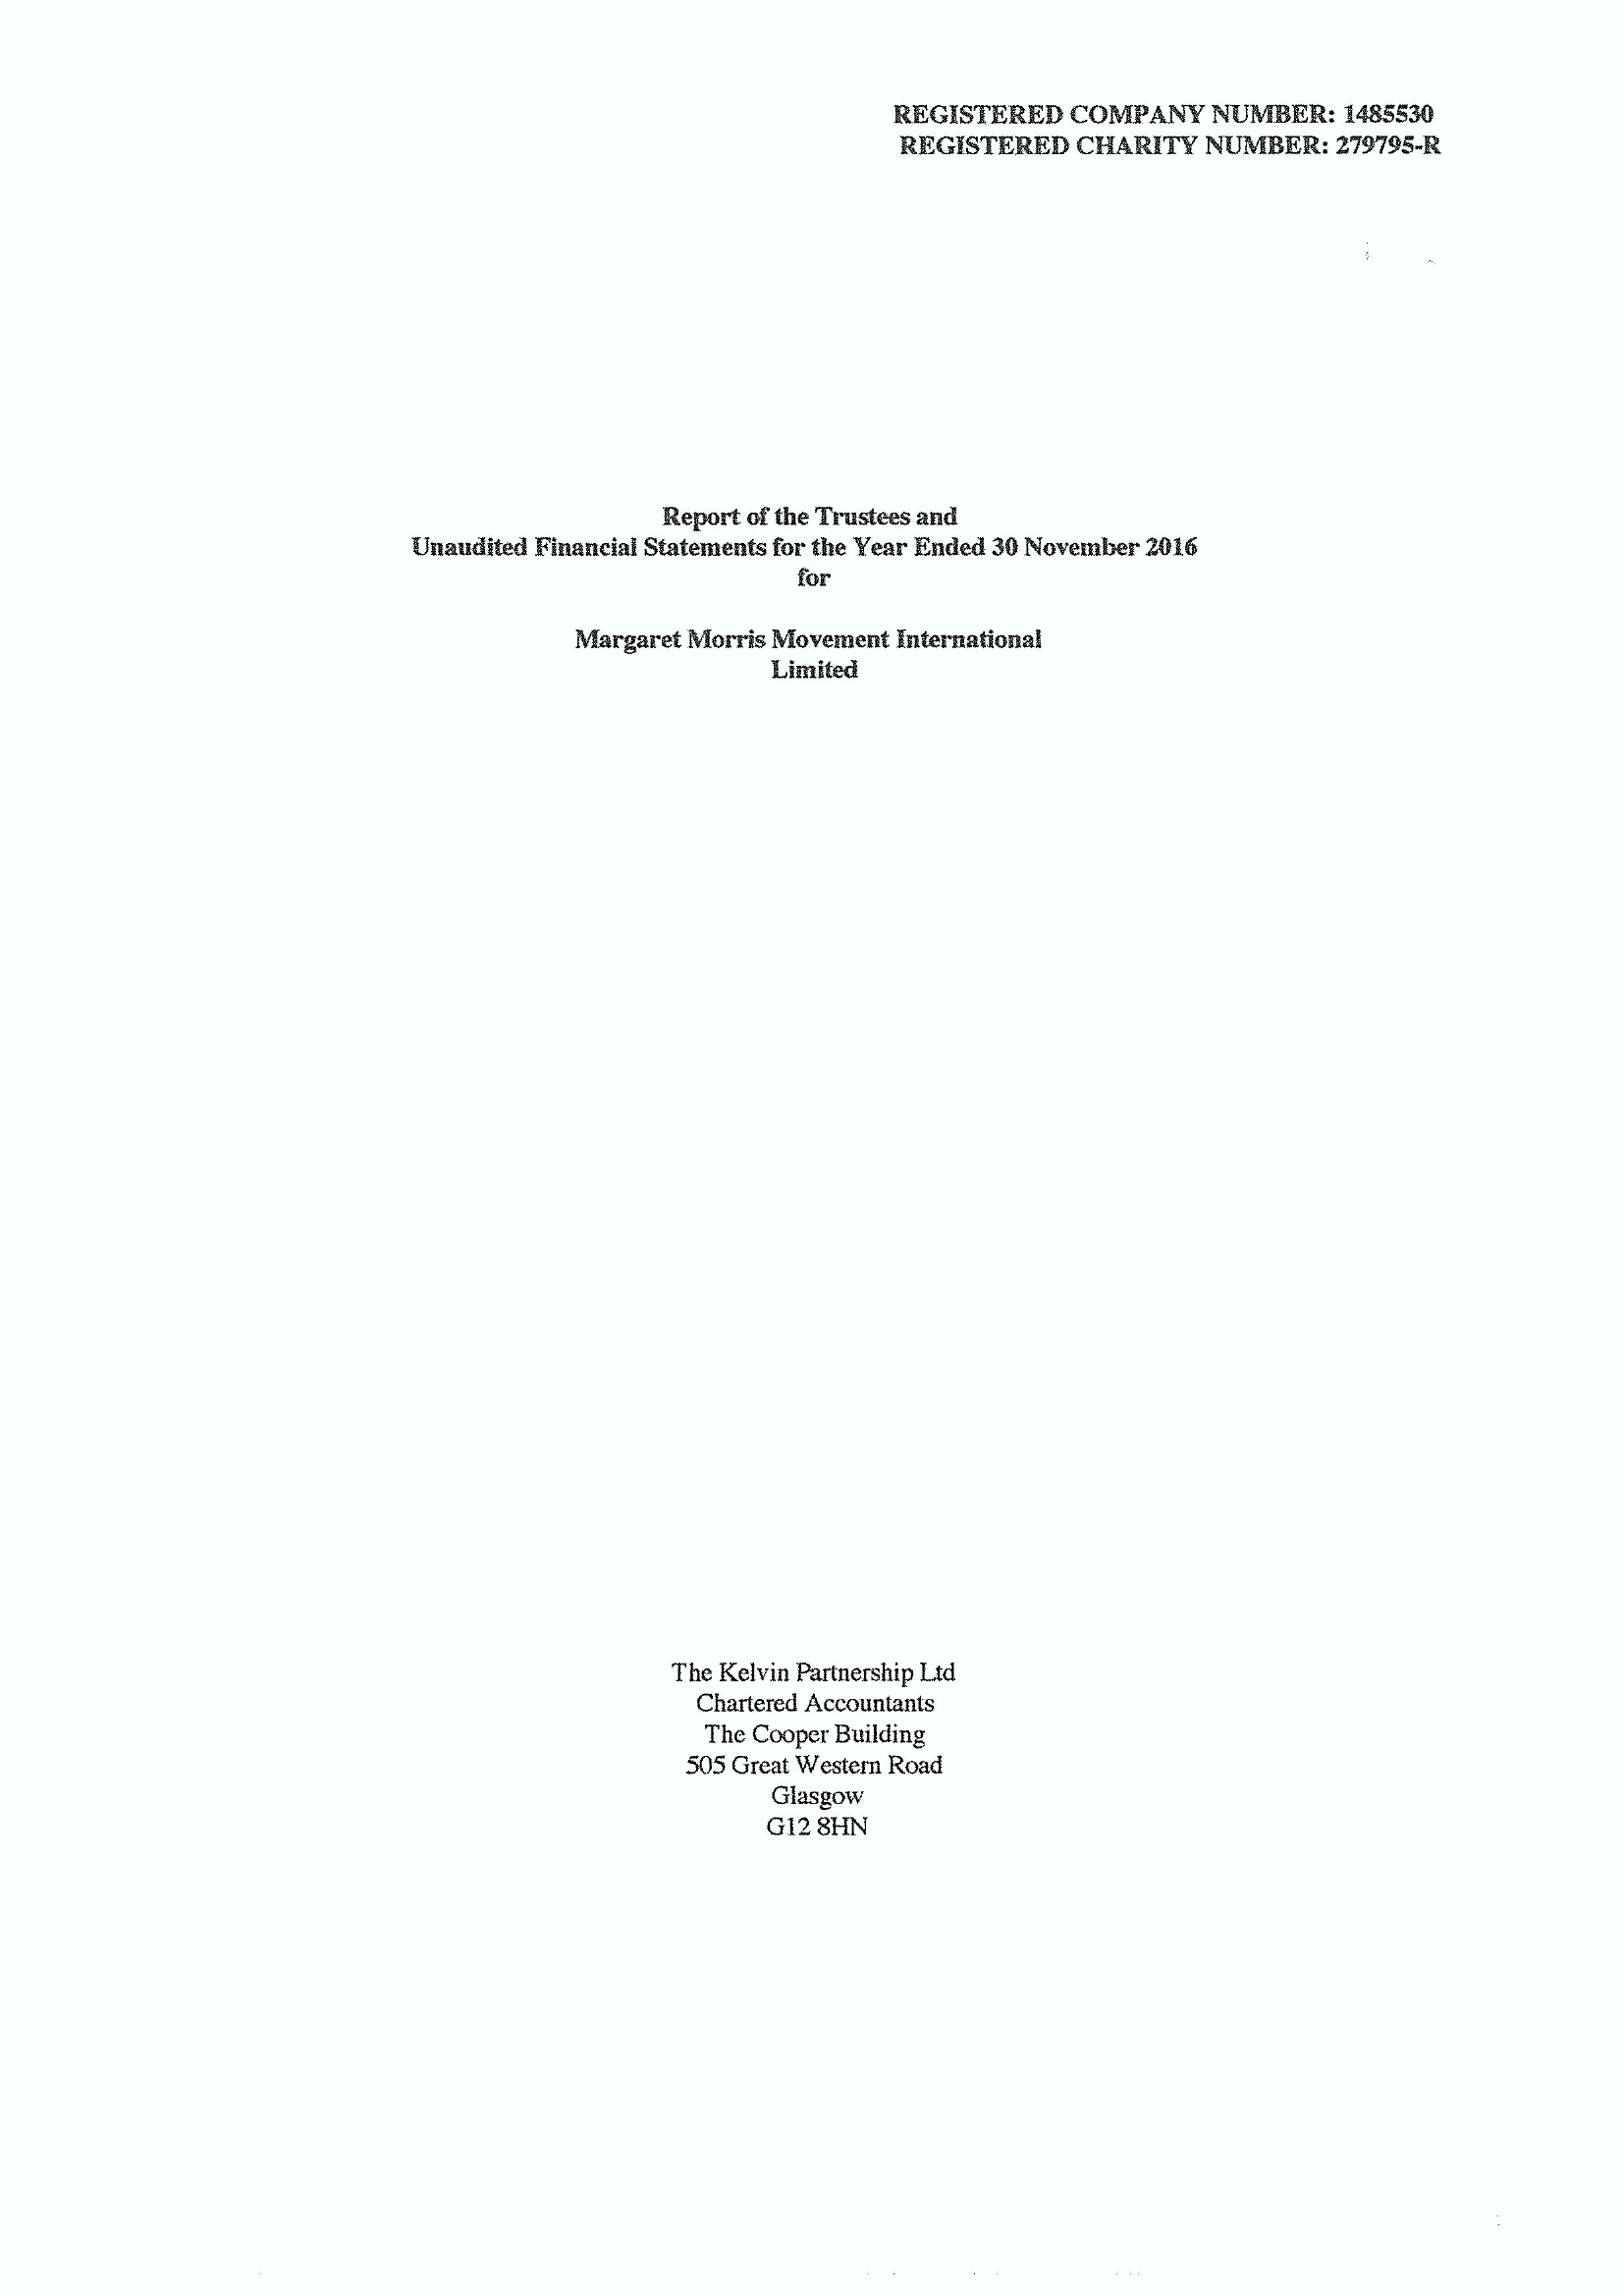

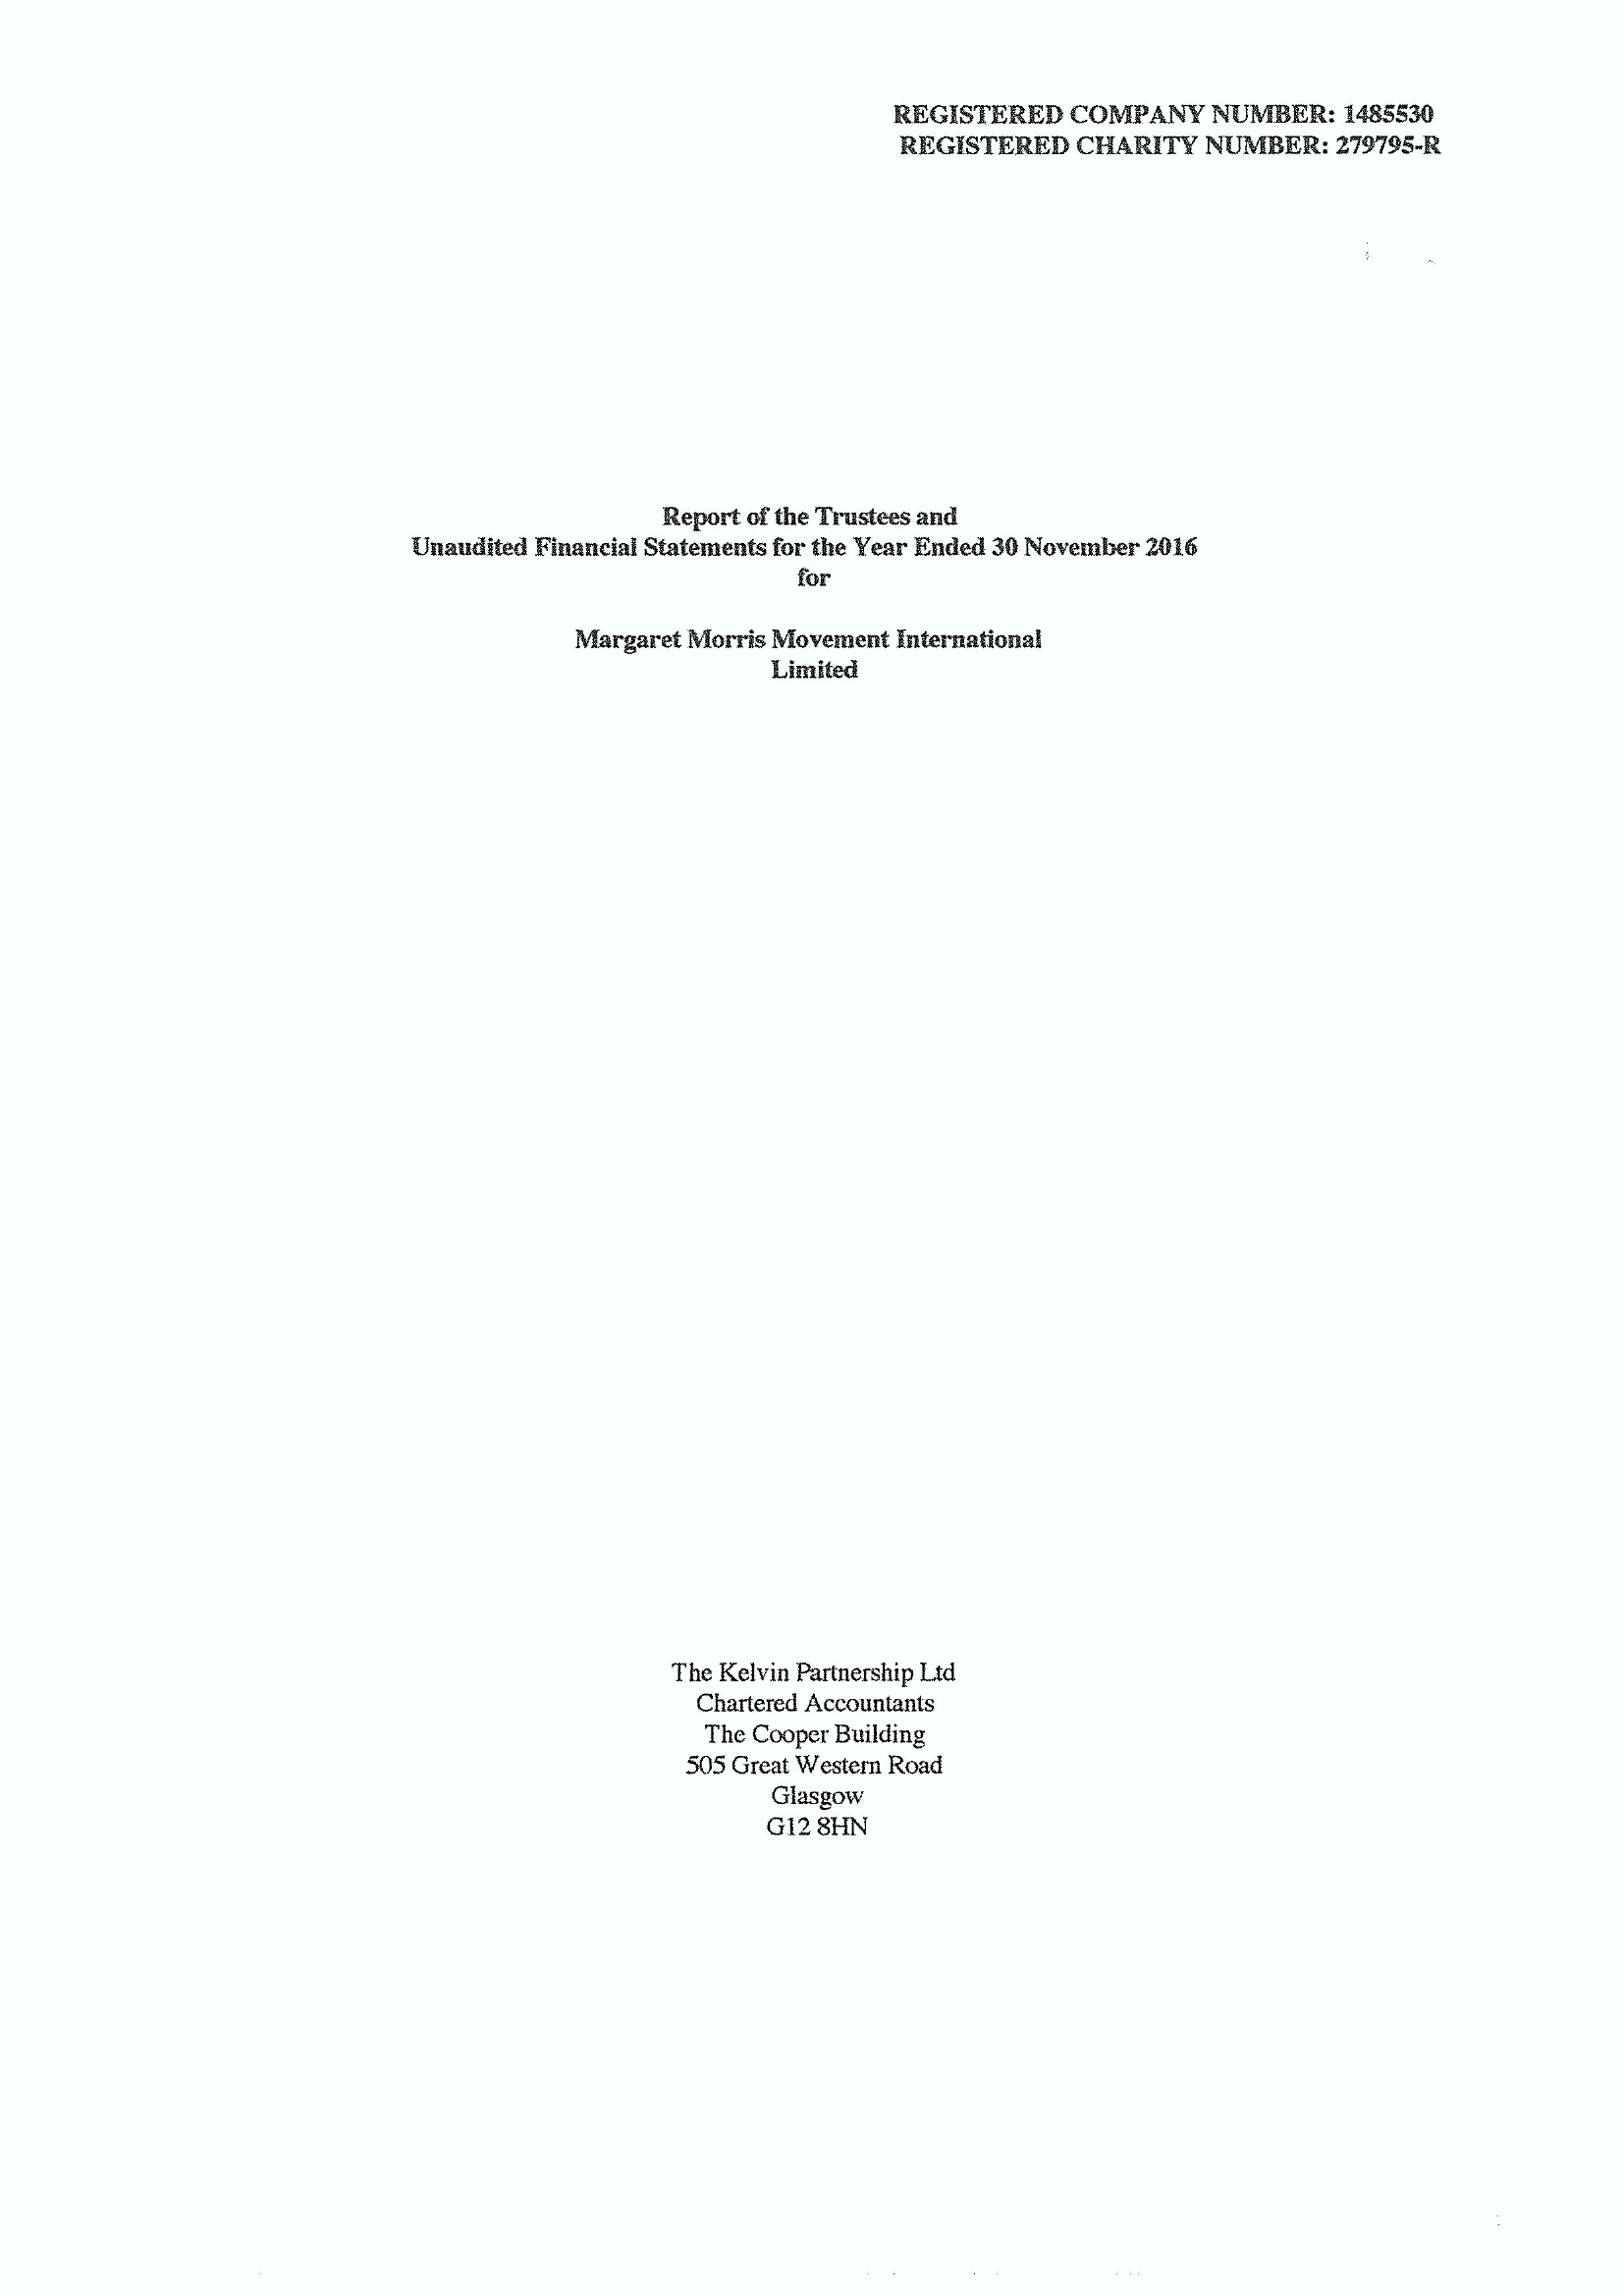

In [9]:
#Preview pdfs in the duplicate list
from pdf2image import convert_from_path, convert_from_bytes
from IPython.display import Image 

for d in dupelist.filename:

    with open(d, 'rb') as f:
        bytes = f.read()
        #convert first page to image
        image = convert_from_bytes(bytes, first_page=1, last_page=1)
        #display image inline
        display(image[0])
#Margaret Morris Movement - 4 dupes!

# Similarity hunting

In [5]:
filelist = glob.glob("data/*.tsv")
print(filelist)

['data/expected-original.tsv', 'data/in.tsv', 'data/test.tsv']


In [7]:
import pandas as pd

df = pd.read_csv('data/in.tsv',header=None,sep="\t")

#Removes line breaks
df = df.replace(r'\\n',' ', regex=True) 

#Check for NAs
print(df.isna().sum())

#Use text extracted via two methods
df = df.iloc[:,[0,5]]

#Label columns
df.columns = ['filename','text']

0     0
1     0
2    45
3     1
4     1
5     0
dtype: int64


In [8]:
#Retrieve labels - charity numbers
labels = pd.read_csv('data/expected-original.tsv',header=None,sep="\t")
regex = "(charity_number=)(\d*)"
ylabels = labels[0].str.extract(regex)
labels = ylabels[1]
labels

0       1156398
1       1165525
2        271547
3       1076235
4        702321
         ...   
1724    1156398
1725     326446
1726    1111593
1727    1079575
1728    1164704
Name: 1, Length: 1729, dtype: object

In [9]:
#Function for preprocessing text
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

def preprocessor(text):
    #tokenize words
    words = nltk.word_tokenize(text)
    #convert to lowercase
    words = [w.lower() for w in words]
    #remove stopwords
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    #remove words less that 3 characters
    words = [x for x in words if len(x) > 3]
    #remove punctuation
    words=[word.lower() for word in words if word.isalpha()]
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    words =[lemmatizer.lemmatize(w) for w in words]
    return words

In [10]:
#Apply preprocessing steps
df['preprocess'] = df['text'].apply(lambda x : preprocessor(x))
docs = df.preprocess
docs = docs.astype('string')

0       [august, trustee, annual, report, period, peri...
1       [receipt, payment, account, period, start, per...
2       [welcome, annual, report, first, time, combine...
3       [annual, repor, account, year, ended, march, c...
4       [greenway, centre, registered, charity, number...
                              ...                        
1724    [august, trustee, annual, report, period, peri...
1725    [gordon, russell, trust, charity, trustee, rep...
1726    [charity, period, start, date, period, date, r...
1727    [caspari, foundation, company, number, registe...
1728    [registered, company, number, england, wale, r...
Name: preprocess, Length: 1729, dtype: object

In [13]:
#Much shorter way to transform words to vectors
from sklearn.feature_extraction.text import TfidfVectorizer 

#Initialize
tfidf_vectorizer=TfidfVectorizer(use_idf=True, min_df=0.01) 

#Then just send all docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

# Small TfidfVectorizer function

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfvec(docs, min_df=0.2):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.8, max_features=200000,
                                 min_df=min_df,preprocessor=None, tokenizer=None)
    # just send in all your docs here
    fitted_vectorizer=tfidf_vectorizer.fit(docs)
    tfidf_vectorizer_vectors=fitted_vectorizer.transform(docs)
    X = tfidf_vectorizer_vectors
    print(tfidf_vectorizer_vectors.shape)
    return X, fitted_vectorizer

X, fitted_vectorizer = tfidfvec(docs, min_df=0.01)

(1729, 6932)


In [175]:
#Calculate cosine similarity
cosinesimilarity = (X * X.T).toarray()
df_sim = pd.DataFrame(cosinesimilarity, index=df.filename, columns=df.filename)

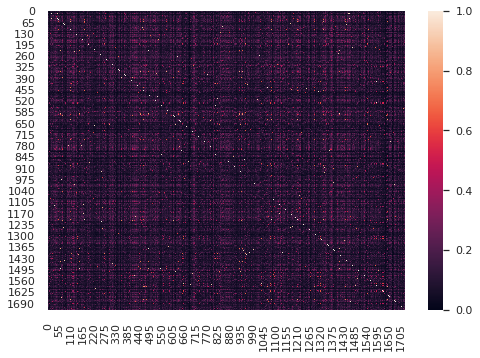

In [146]:
#Heatmap of cosine similarity
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

ax = sns.heatmap(cosinesimilarity)
#1700+ docs - not much similarity based on 6000+ features

In [174]:
#Function to search for similar files
pdffile='008482cf51383c158b54e593cfa5fbf7.pdf'

def similardoc(pdffile, n=5):
    tmp=df_sim.loc[pdffile]
    result = tmp.sort_values(ascending=False).head(n)
    return result

similardoc(pdffile)

filename
008482cf51383c158b54e593cfa5fbf7.pdf    1.000000
8627b99daab7a904ddd2ea767e50c007.pdf    0.875548
ff80d979460073ac05715369dbe22137.pdf    0.829965
a686cda6f822e2e32c747689924c193d.pdf    0.676236
7358c944edc00964365dd74ac11a4011.pdf    0.675917
Name: 008482cf51383c158b54e593cfa5fbf7.pdf, dtype: float64

In [38]:
#Show parameters of vectorizer - a lot of potential here to optimize parameters
fitted_vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [39]:
len(fitted_vectorizer.get_feature_names())

6932

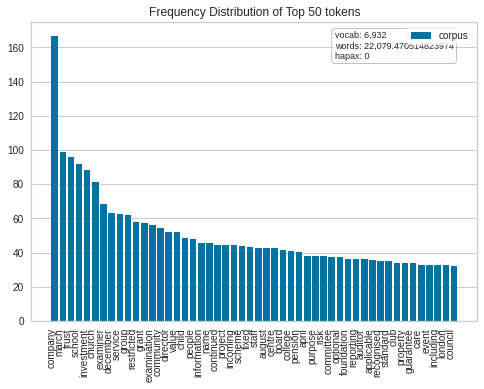

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [43]:
#Plots the token frequency
from yellowbrick.text import FreqDistVisualizer
visualizer = FreqDistVisualizer(features=fitted_vectorizer.get_feature_names(), orient='v')
visualizer.fit(X)
visualizer.show()

In [50]:
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import sys
from time import time
from collections import Counter

def kcluster(X):
    #Initialize
    km = KMeans(n_clusters=8, init='k-means++', max_iter=1000, n_init=10,
                verbose=0)
    
    print("Clustering sparse data with %s" % km)
    t0 = time()
    
    km.fit(X)
    km.predict(X)
    km_labels = km.labels_
    X_trans = km.transform(X)

    #Verbose info
    print("done in %0.3fs" % (time() - t0))
    
    #Clustering metric
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))
    
    clustercounts = Counter(km_labels)
    print(clustercounts)

    #Plot
    plt.scatter(X_trans[:, 0], X_trans[:, 1], c=km.labels_, s=20, cmap='viridis')
    #cmaps['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    return km_labels, km

Clustering sparse data with KMeans(max_iter=1000)
done in 5.140s
Silhouette Coefficient: 0.043
Counter({7: 536, 4: 368, 6: 215, 1: 211, 0: 132, 2: 127, 5: 95, 3: 45})


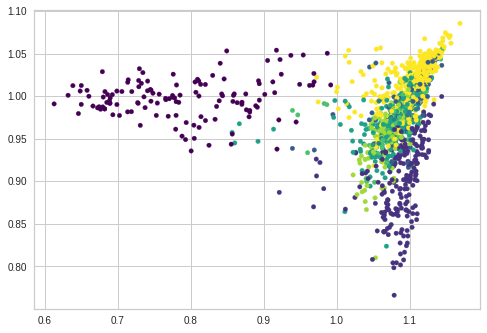

In [51]:
#Run clustering
km_labels, km = kcluster(X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

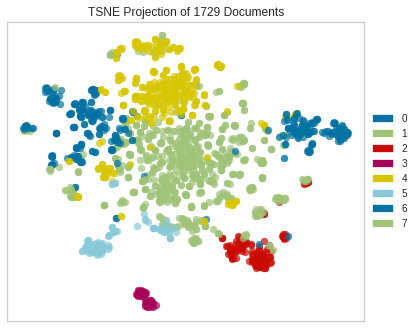

<AxesSubplot:title={'center':'TSNE Projection of 1729 Documents'}>

In [52]:
#Apply TSNE to help visualise clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer

#Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
#Fit tsne on tfidf scores
tsne.fit(X, km_labels, metric='cosine')
#Visualise
tsne.show()

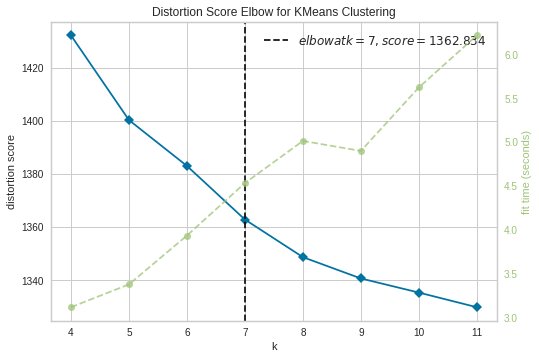

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(km, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

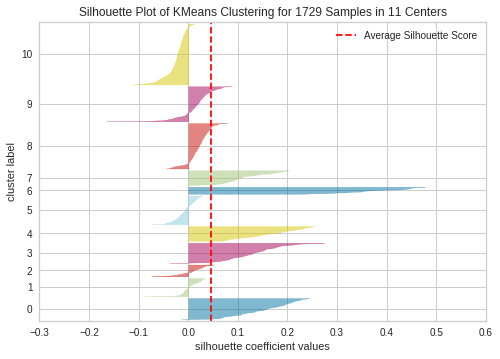

/home/becode/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1729 Samples in 11 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick', model=None)

In [56]:
#Plot to sihouette scores too evaluate the clusters
#High scores indicate good clusters,negative scores indicate poor clustering
from yellowbrick.cluster import silhouette_visualizer

silhouette_visualizer(km, X, colors='yellowbrick')

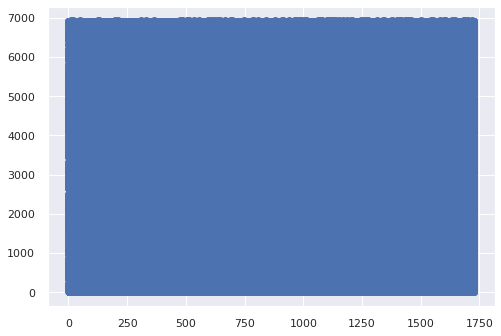

In [177]:
import hdbscan
import seaborn as sns
clusterer = hdbscan.HDBSCAN(metric='cosine')
clusterer.fit(X)
clusterer.labels_

plt.scatter(xy[:, 0], xy[:, 1])

#tsne.fit(X, clusterer.labels_, metric='cosine')
#Visualise
#tsne.show()

In [82]:
hdb = clusterer.fit(X)
dir(hdb)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_condensed_tree',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_metric_kwargs',
 '_min_spanning_tree',
 '_more_tags',
 '_outlier_scores',
 '_prediction_data',
 '_raw_data',
 '_relative_validity',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_single_linkage_tree',
 '_validate_data',
 'algorithm',
 'allow_single_cluster',
 'alpha',
 'approx_min_span_tree',
 'cluster_persistence_',
 'cluster_selection_epsilon',
 'cluster_selection_method',
 'condensed_tree_',
 'core_dist_n_jobs',
 'exemplars_',
 'fit',
 'fit_predict',
 'gen_min_span_tree',
 

/home/becode/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/becode/.local/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

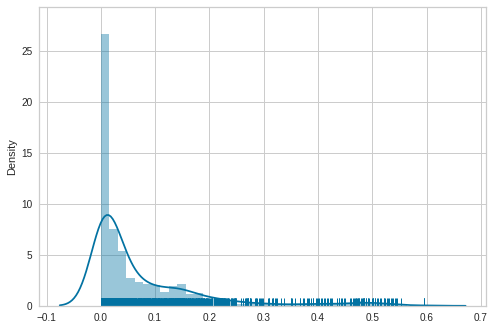

In [106]:
#Plot outliers from hdbscan
sns.distplot(hdb.outlier_scores_[np.isfinite(hdb.outlier_scores_)], rug=True)

In [190]:
from sklearn.manifold import TSNE
projection = TSNE().fit_transform(X)

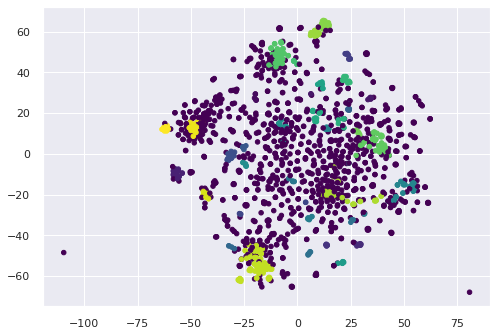

In [180]:
plt.scatter(*projection.T, c=hdb.labels_, s=20, cmap='viridis')

#It looks mostly purple, how many clusters are there?

In [196]:
from collections import Counter, OrderedDict

clustercounts = Counter(hdb.labels_)
print(clustercounts.most_common())
#OrderedDict(clustercounts.most_common())

[(-1, 1201), (29, 75), (23, 49), (24, 46), (14, 37), (28, 28), (31, 26), (26, 21), (2, 19), (7, 16), (27, 16), (19, 15), (16, 13), (21, 13), (30, 12), (32, 12), (11, 11), (18, 9), (25, 9), (5, 9), (3, 9), (20, 8), (1, 8), (13, 7), (4, 6), (10, 6), (8, 6), (9, 6), (12, 6), (6, 6), (22, 6), (15, 6), (17, 6), (0, 6)]


# Hunting for outliers

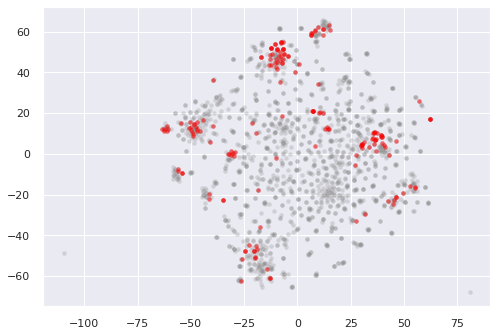

In [181]:
#set outlier threshold at 90th percentile
threshold = pd.Series(hdb.outlier_scores_).quantile(0.9)
#filter to make outlier list
outliers = np.where(hdb.outlier_scores_ > threshold)[0]
#plot data in grey
print('Number of outliers:', len(outliers))
plt.scatter(*projection.T, s=20, linewidth=0, c='gray', alpha=0.25)
#plot outliers in red
plt.scatter(*projection[outliers].T, s=20, linewidth=0, c='red', alpha=0.5)

In [188]:
#Get list of outliers
df.loc[outliers]

,filename,text,preprocess
0,008482cf51383c158b54e593cfa5fbf7.pdf,TAR 1 August 2016 Trustees' Annual Report for ...,"[august, trustee, annual, report, period, peri..."
2,01c7fd563327947c68abdd9717ef228d.pdf,54 S ke * B Welcome to our Annual Report for...,"[welcome, annual, report, first, time, combine..."
7,0238f9c4db79d3736d2aff898ac5802e.pdf,KIMICHI SCHOOL - CRN 7968584 A Private Limited...,"[kimichi, school, private, limited, company, g..."
14,030d80fea4fc1ac8d3d8f366ec92bd21.pdf,Charity Registered No^r083995/ Company Registe...,"[charity, registered, company, registere, meth..."
31,053c62960b1bb256b2e918ccabd738a6.pdf,THE GODOLPHIN AND LATYMER SCHOOL FINANCIAL STA...,"[godolphin, latymer, school, financial, statem..."
...,...,...,...
1675,f54c3b386f86e71813ff2cc9ac22a8e2.pdf,Trustees' Annual Report for the period ULt (OM...,"[trustee, annual, report, period, ommission, p..."
1680,f6d48ec7afc905d8221185f6fe34287c.pdf,Eastbourne College (Incorporated) ANNUAL REPO...,"[eastbourne, college, incorporated, annual, re..."
1704,fc2ee8284700d4fa58925ef83af8cf73.pdf,"1 D H z c , D D r r L ) r L - ) — — O j Z H H ...","[methodist, home, board, director, report, inc..."
1709,fd55ffda294272d01b02f4d71fe91e3f.pdf,Lycee International de Londres Annual Report a...,"[lycee, international, londres, annual, report..."


# Similarity using layout

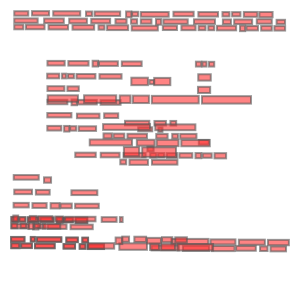

In [136]:
multi_polygon[1:200]

In [183]:
#Function to get coordinates of all text in pdf
#pdfminer not userfriendly
from pdfminer.layout import LAParams, LTTextBox
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
import glob

def textcoord(file):
    fp = open(file, 'rb')
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    pages = PDFPage.get_pages(fp)
    
    #Make an empty dictionary
    dic = {'x':[],'y':[],'text':[]}
    
    for page in pages:
        print('Processing next page...')
        interpreter.process_page(page)
        
        #Get layout
        layout = device.get_result()
        
        #Loop through items in layout
        for lobj in layout:
            
            #Check for text boxes
            if isinstance(lobj, LTTextBox):
                
                #For every textbox get the bbox coordinates and text
                #x0, x1, y0, y1 = lobj.bbox[0], lobj.bbox[1],lobj.bbox[2],lobj.bbox[3]
                print(lobj.bbox)
                #lobj.get_text()
                #print('At %r is text: %s' % ((x, y), text))
                '''
                #Make a dictionary
                dic['x'].append(x)
                dic['y'].append(y)
                dic['x'].append(x)
                dic['y'].append(y)
                
                dic['text'].append(text)
                '''
textcoord(file)


Processing next page...
(234.96, 774.83282, 542.46, 797.54199)
(248.64, 636.65445, 348.14943999999997, 646.81962)
(170.16, 624.54248, 292.75986, 633.72342)
(295.92, 614.07709, 433.04, 635.52396)
(219.36, 590.93944, 295.08849000000004, 600.6194399999999)
(311.28, 580.60295, 381.3757, 600.82266)
(279.84, 580.31174, 304.35477999999995, 588.09174)
(256.8, 569.07861, 346.02122, 578.2626600000001)
Processing next page...
(58.32, 771.86559, 134.24854, 792.25416)
(92.64, 771.8829499999999, 192.43902, 781.8660600000001)
(149.76, 784.09691, 220.3357, 793.48785)
(58.8, 736.95709, 200.57931, 759.46338)
(121.44, 577.8956800000001, 206.38096, 588.82338)
(121.44, 555.43767, 244.94912, 565.3704)
(121.68, 531.82262, 249.08766, 542.96262)
(121.68, 508.73228, 176.2558, 517.9286999999999)
(121.2, 486.90096, 250.75986, 496.44342)
(121.68, 464.38262000000003, 285.85321, 475.52262)
(385.44, 602.37134, 402.89712000000003, 611.35134)
(384.0, 509.80685, 405.24710000000005, 521.75685)
(384.48, 487.89741, 406.296

(56.88, 759.86559, 256.23962, 795.44262)
(91.44, 760.12295, 191.22122, 770.2626600000001)
(148.56, 772.33691, 218.8957, 781.72785)
(57.6, 736.09908, 402.27416, 749.44803)
(57.84, 679.93908, 288.45912000000004, 725.22369)
(207.12, 693.09134, 237.54424, 702.07134)
(172.08, 692.6590799999999, 198.8418, 701.4190799999999)
(111.84, 702.99427, 138.38795000000002, 711.68427)
(244.56, 693.40729, 294.34000000000003, 702.37635)
(145.2, 703.00729, 446.1885, 715.78338)
(421.44, 694.83123, 540.40481, 717.71631)
(298.56, 682.83644, 357.31516, 702.91389)
(350.4, 682.84946, 390.64758, 691.76427)
(366.24, 694.31087, 415.13969, 703.70709)
(92.4, 657.12172, 154.28853999999998, 666.38181)
(160.56, 657.85691, 173.715, 666.62691)
(180.0, 658.12512, 282.72195, 667.88445)
(289.2, 659.22096, 344.78403000000003, 668.34096)
(352.8, 659.32946, 384.40092, 667.94946)
(393.6, 660.09503, 533.3036000000001, 669.86709)
(59.04, 645.4029499999999, 103.9681, 665.17635)
(113.52, 644.9793699999999, 192.75704999999996, 654.8

(57.6, 770.9229499999999, 133.28854, 790.76682)
(91.68, 771.1043599999999, 191.46122, 781.5426600000001)
(148.8, 782.8969099999999, 219.1357, 792.52785)
(58.08, 736.51832, 221.53321000000003, 759.46338)
(59.28, 679.04331, 175.09696000000002, 690.09792)
(59.52, 611.55861, 176.09459, 666.1809599999999)
(60.72, 540.96606, 186.07358, 573.99)
(61.44, 484.28483, 123.3545, 504.97143)
(111.6, 496.24577, 138.65536, 505.43577)
(129.12, 485.58031, 154.35008000000002, 494.15031)
(61.68, 438.72823, 203.62707, 470.82369)
(62.64, 390.97387, 165.68768000000003, 401.22369)
(62.64, 356.09792, 178.77507, 366.79953)
(62.88, 129.06096, 168.72864, 342.90369)
(437.52, 718.14291, 467.92, 728.91291)
(503.52, 719.12895, 533.84, 729.77895)
(456.0, 488.66472, 470.76, 498.50472)
(515.28, 488.71246, 537.195, 499.19067)
(440.64, 394.88548, 471.71999999999997, 405.14472)
(506.64, 395.57293, 537.945, 405.85689)
(441.84, 614.77973, 469.32, 658.95)
(442.8, 590.4767999999999, 469.965, 600.5697299999999)
(443.04, 545.1688

'\n#Get list of pdfs in documents folder\nfilelist = glob.glob("/home/becode/dr-robin/kleister-charity/documents/*.pdf")\n#print(filelist)\n\nfor f in filelist:\n    #get coordinates\n    textcoord(file)\n'

# Small function to convert pdf to image

In [112]:
import pdf2image
import numpy as np
import cv2

def pdf2array(file):
    img = pdf2image.convert_from_path(file)
    #img = np.asarray(img[0])
    #edge_img = cv2.Canny(img,10,20)
    return img

# Finally a way to get layout coordinates from a pdf

In [11]:
# Get dimensions from pdf
import re, subprocess
from bs4 import BeautifulSoup

def pdfdim(file):
    command  = ['pdftotext', '-bbox-layout', file, '-']
    #command = ['pdftotext', '-f i', '-l i', '-bbox-layout', file]
    output   =  subprocess.check_output(command).decode()
    soup = BeautifulSoup(output, 'html.parser')
    #block = soup.find_all('block')
    results = soup.find_all("block")
    results

# Very useful to get all bboxes

In [129]:
# Function to get all bboxes
from shapely.geometry import box
import geopandas
import shapely.geometry as geom
import re, subprocess
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import sys

def pdflayout(pdf_file):
    output=""
    output = subprocess.check_output(['pdftotext','-f','1', '-bbox-layout', pdf_file,'-']).decode()
    soup = BeautifulSoup(output, 'html.parser')
    
    block = soup.find_all('word')
    bboxes=[]
    pdfgdf= geopandas.GeoDataFrame()
    for b in block:
        l = box(float(b['xmin']),float(b['ymin']),float(b['xmax']),float(b['ymax']))
        bboxes.append(l)
    gdf = geopandas.GeoDataFrame(geometry=bboxes)
    polys = gdf.geometry.tolist()
    multi_polygon = geom.MultiPolygon(polys)
    multi_polygon = geopandas.GeoDataFrame(geometry=polys)
    pdfgdf.append(multi_polygon)

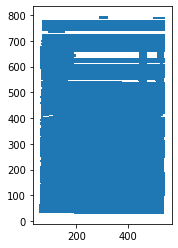

In [256]:
#A work in progress
gdf.plot()
plt.show()

# Thanks for listening

In [ ]:
# Get dimensions of pdf

import re, subprocess
from bs4 import BeautifulSoup

def pdfdim(file):
    command  = ['pdftotext', '-bbox-layout', file, '-']
    output   =  subprocess.check_output(command).decode()
    soup = BeautifulSoup(output, 'html.parser')
    dim = soup.find('page')
    height = dim.get('height')
    width = dim.get('width')
    return height, width

# Function to get all info for a pdf

In [157]:
def pdfinfo(file):
    command  = ['pdfinfo', file]
    output   =  subprocess.check_output(command).decode()
    return output

In [290]:
'''
Random annotation leads to
- Inconsistent annotation
- Slow annotation

• Goal is to speed up annotation so that similar documents are handled by same person which speeds up short term memory retention and
improves consistency

• We’ll rather have 100% automation on 90% of the documents than 80% automation on 95% of the documents. That means we want to ignore
outliers as they provide less value.

So the goal is
• Automatically detect clusters of documents that are very similar. For large clusters, we want to limit the annotation to e.g. 20 docs until the
model recognizes them correctly.
• Find outliers of documents that don’t look like anything else (so we can ignore them)
• Flag duplicates or near duplicates (e.g. different scan of same document might have some other OCR artifacts, but we essentially the same) for
removal because they can make the results on the test set over-optimistc.
• For any given document, be able to query the top n most similar documents. This can be useful for finding how similar documents were
annotated in the past to improve consistency.

• Techniques
My first try would be a simple tf-idf based clustering. That should work well enough, but more advanced methods like document embeddings are
possible too. Rather than optimizing the document embedding part, I would personally spend more time on tuning the clustering so that it
automatically detects reasonable clusters. You need good cut-offs to decide what is an outlier, which documents are similar,
'''

'\nRandom annotation leads to\n- Inconsistent annotation\n- Slow annotation\n\n• Goal is to speed up annotation so that similar documents are handled by same person which speeds up short term memory retention and\nimproves consistency\n\n• We’ll rather have 100% automation on 90% of the documents than 80% automation on 95% of the documents. That means we want to ignore\noutliers as they provide less value.\n\nSo the goal is\n• Automatically detect clusters of documents that are very similar. For large clusters, we want to limit the annotation to e.g. 20 docs until the\nmodel recognizes them correctly.\n• Find outliers of documents that don’t look like anything else (so we can ignore them)\n• Flag duplicates or near duplicates (e.g. different scan of same document might have some other OCR artifacts, but we essentially the same) for\nremoval because they can make the results on the test set over-optimistc.\n• For any given document, be able to query the top n most similar documents. Thi

In [ ]:
#convert to slide
jupyter nbconvert Pdf_layout_extraction-Copy1.ipynb  --slides --post serve